# Classification of Cancer associated Mutations from Literature using Machine Learning

Use the "Run" button to execute the code.

In [8]:
pip install jovian --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None


In [1]:
import jovian

<IPython.core.display.Javascript object>

In [190]:
# Execute this to save new versions of the notebook
jovian.commit(project="cancer-mutations-ml-160422",filename="cancer-mutations-ml-160422.ipynb")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "anubratadas/cancer-mutations-ml-160422" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/anubratadas/cancer-mutations-ml-160422


'https://jovian.ai/anubratadas/cancer-mutations-ml-160422'

### <font color='green'>Import the essential libraries</font>

In [2]:
#import jovian
import pandas as pd
import numpy as np
#import requests
#import xml.etree.ElementTree as ET
#import time
import re
from tqdm import tqdm
from collections import Counter
from scipy.special import factorial
from numpy import random
import pickle
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# sns.set_style('darkgrid')
# matplotlib.rcParams['font.size'] = 14
#matplotlib.rcParams['figure.figsize'] = (9, 5)
# matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [5]:
tqdm.pandas(desc="progress bar")

In [6]:
#!pip install nltk
#!pip install xgboost
#!pip install bioservices

In [7]:
from Bio.KEGG import REST
from bioservices.kegg import KEGG
#from collections import deque
import networkx as nx
from IPython.display import Image
import time
import re

In [8]:
import string
import nltk
nltk.download('words')
from nltk.corpus import words
words=nltk.corpus.words.words()
from nltk.probability import FreqDist

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\anubr\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

 ### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"> A cancerous tissue can have thousands of genetic mutations (Variations), which are discovered using genome sequencing. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. MSKCC intends the Data scientist to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.</font>

<a id='top'>**Beginning of Notebook**</a>

[model train text data](#train_data)

### <font color='green'>Exploratory Data Analysis</font>

###  references
  - https://github.com/ghostintheshellarise/2021HackForRare
  - https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html
  - https://bioservices.readthedocs.io/en/master/kegg_tutorial.html
  - https://bioservices.readthedocs.io/en/master/index.html

#### train data

In [10]:
train_text_df = pd.read_csv('training_text.zip', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"],compression='zip')

In [11]:
train_variant_df = pd.read_csv('training_variants.zip',compression='zip')

In [12]:
train_text_df.shape, train_variant_df.shape

((3321, 2), (3321, 4))

In [13]:
train_text_df.columns, train_variant_df.columns

(Index(['ID', 'Text'], dtype='object'),
 Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object'))

In [14]:
# merging the text and variation data
train_df = pd.merge(train_variant_df,train_text_df,on='ID')

In [15]:
train_text_df.head(n=4)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


In [16]:
train_variant_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [17]:
train_df.shape

(3321, 5)

In [18]:
train_df.loc[0,:]

ID                                                           0
Gene                                                    FAM58A
Variation                                 Truncating Mutations
Class                                                        1
Text         Cyclin-dependent kinases (CDKs) regulate a var...
Name: 0, dtype: object

In [19]:
# taking a sample of the dataset
#train_df = train_df.sample(frac=0.2,random_state=222)

In [20]:
#train_df=train_df.groupby('Class',group_keys=False).apply(lambda x: x.sample(frac=0.2)) # proportionate sampling

We have taken a sample of the training data

In [23]:
train_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [22]:
#train_df['Variation'].tolist()

In [22]:
def common_mutations(text):
    match_pat = re.compile('([\s][A-Z][\d][\d][\d][A-Z][\s])')
    if isinstance(text,str):
        xval=Counter(re.findall(match_pat,text))
        if xval.most_common(1):
            return xval.most_common(3)
        return "NA"
    return "NA"

In [23]:
def common_mutations_len(text):
    if isinstance(text,str):
        match_pat = re.compile('([\s][A-Z][\d][\d][\d][A-Z][\s])')
        xval=Counter(re.findall(match_pat,text))
        return len(xval)
    return 0

In [26]:
train_df["commn mutations"]=train_df['Text'].map(common_mutations_len)

In [32]:
train_df[train_df['Class']==2]

,ID,Gene,Variation,Class,Text
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
33,33,TERT,Amplification,2,The current World Health Organization classifi...
71,71,CCND2,Amplification,2,"The cyclin-dependent protein kinases, or cdks,..."
75,75,CCND3,Amplification,2,"The cyclin-dependent protein kinases, or cdks,..."
76,76,CCND3,P284L,2,OF THE GENERALIZATIONS TO emerge from studies ...
80,80,CCND3,I290A,2,The activities of cyclin D-dependent kinases s...
81,81,CCND3,I290R,2,OF THE GENERALIZATIONS TO emerge from studies ...
84,84,RIT1,A77T,2,Abstract RASopathies are autosomal dominant d...
97,97,TGFBR2,R537P,2,Transforming growth factor β (TGFβ) plays a ke...


![](https://imgur.com/kO8UAXb.png)

image courtesy http://igbiologyy.blogspot.com/2014/03/chromosomes-dna-genes-and-alleles.html

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"><i>Gene</i> is a stretch of DNA encoding a specific functional molecule, a protein. Variation is <i>Mutation</i>,  which occurs in the gene and changes the function of the protein. Proteins are made up of 20 amino acids and these are designated by the following alphabets; A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y and V. In the variation column, the first alphabet is the orginal amino acid, the number is the physical position in the gene where the change has occured and the last alphabet is the changed amino acid. The Text dataset contains the information for the Gene, the Variation and the Class column in the variants dataset. The 2 datasets are linked by the common ID column</font>

### The distribution of mutations per gene in the dataset

In [25]:
mutation_pattern=train_df.groupby(['Gene'])[['Variation']].aggregate("count").sort_values("Variation",ascending=False)

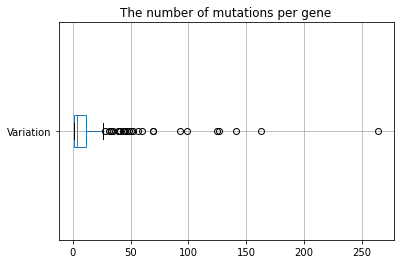

In [26]:
mutation_pattern[['Variation']].boxplot(vert=False);
plt.title("The number of mutations per gene");

In [19]:
mutation_pattern.shape

(264, 1)

In [104]:
mutation_pattern['Variation'].median()

4.0

In [21]:
mutation_pattern['Variation'].mode()

0    1
dtype: int64

In [22]:
def poisson(k, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**k/factorial(k)) * np.exp(-lamb)

In [23]:
lamb=mutation_pattern['Variation'].mean()

In [24]:
k=mutation_pattern['Variation'].to_numpy()

In [25]:
k=np.sort(k)

In [26]:
y=poisson(k,lamb)

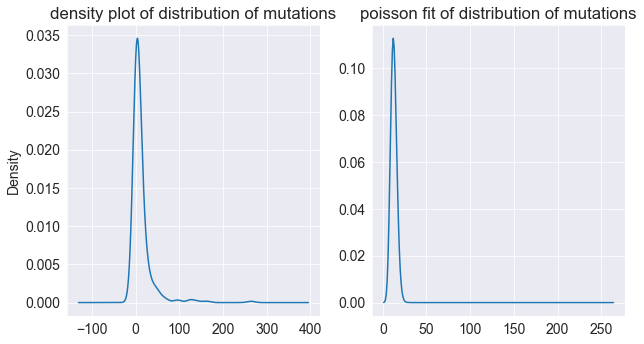

In [27]:
plt.subplot(1,2,1)
mutation_pattern['Variation'].plot.density();
plt.title("density plot of distribution of mutations")
plt.subplot(1,2,2)
plt.plot(k,y);
plt.title("poisson fit of distribution of mutations")
plt.tight_layout()

In [28]:
mutated_genes=train_df['Gene'].to_list()

### <font style="font-size:18px;font-family:arial;color:blue;text-indent:100px;line-height: 0.8;word-spacing: 10px"> Mutation acquisition is a rare event. The Poisson distribution is used to describe the distribution of rare events in a large population. For example, at any particular time, there is a certain probability that a particular cell within a large population of cells will acquire a mutation.                                                                                   -Frank H. Stephenson, in Calculations for Molecular Biology and Biotechnology (Second Edition), 2010. The distribution of mutations per gene in this dataset follows the usual pattern of Poisson distribution seen in general for mutations. 3321 mutations, or variations, are distributed in 195 genes. 14 genes have more than 20 mutations, which are often classified in different classes. It would be worthwhile to investigate, why certain mutations are classified in certain specific classes </font>

### <font color='green'>The distribution of classes in the dataset </font>

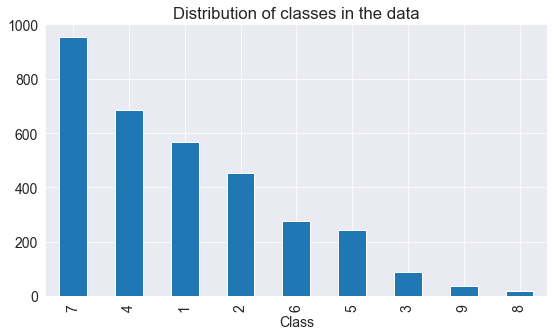

In [29]:
train_df.value_counts('Class').plot(kind='bar');
plt.title("Distribution of classes in the data");

### <font color='blue'>The mutations are distributed into 9 classes, from class 1 to class 9.The distribution of the classes is imbalanced </font>

In [30]:
train_df[train_df['Class']==8]['Gene'].nunique()

12

In [31]:
train_df[train_df['Class']==7]['Gene'].nunique()

108

In [32]:
train_df[train_df['Class']==1]['Gene'].nunique()

142

### <font color="blue"> The largest class, class 7, has 108 genes which is almost half of all the mutated genes, while class 8, the smallest class has 12 genes. Let us see if all genes in class 7 have the same number of mutations per gene </font>

In [24]:
test_variant_df=pd.read_csv('test_variants.zip',compression='zip')

In [25]:
train_variant_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


#### <font color='blue'>Are the position of the mutations for a gene in the train and test datasets same ? </font>

In [35]:
compare_train_test_variant=pd.merge(train_variant_df,test_variant_df,how='outer',left_on='Gene',right_on='Gene')

In [36]:
compare_train_test_variant[compare_train_test_variant['Gene']=='CBL']

,ID_x,Gene,Variation_x,Class,ID_y,Variation_y
1,1.0,CBL,W802*,2.0,1189.0,H398Q
2,1.0,CBL,W802*,2.0,4636.0,S80N
3,2.0,CBL,Q249E,2.0,1189.0,H398Q
4,2.0,CBL,Q249E,2.0,4636.0,S80N
5,3.0,CBL,N454D,3.0,1189.0,H398Q
6,3.0,CBL,N454D,3.0,4636.0,S80N
7,4.0,CBL,L399V,4.0,1189.0,H398Q
8,4.0,CBL,L399V,4.0,4636.0,S80N
9,5.0,CBL,V391I,4.0,1189.0,H398Q
10,5.0,CBL,V391I,4.0,4636.0,S80N


#### <font color='blue'> The position and nature of mutations in the train and test dataset are different,and hence, we cannot transfer the class annotation directly from train to text </font>

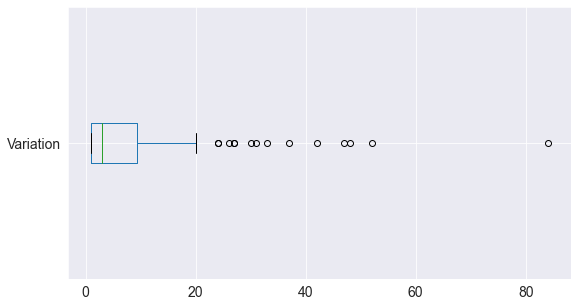

In [37]:
train_df[train_df['Class']==7].groupby('Gene')[['Variation']].count().boxplot(vert=False);

In [38]:
train_df[train_df['Class']==7]['Variation'].nunique()

889

In [47]:
def gene_class(i):
    return train_df[train_df['Class']==i]['Gene'].drop_duplicates().tolist()

In [81]:
class_gene_list=[]
for i in range(1,10):
    var_name='class'+str(i)+"_genes"
    var_name=gene_class(i)
    class_gene_list.append(var_name)    

### <font color='blue'> The pattern of mutations per gene, is same as the overall dataset and hence,no obvious numerical pattern is present in classifying the mutations in class 7. Let us furthere explore a few other possibilites for the classification </font>

### <font color='green'>The Signalling Pathways in Cancer</font>

![](https://i.imgur.com/yk4ib0M.jpg)

### <font color='blue'> Proteins encoded by respective genes, function together in elaborate sequences called <i>Pathways<i> ,to create the final outcome. For cancer, the sequence mostly starts with a signal outside the cell. Proteins called receptors recieve the signal, and pass it on to a sequence of other proteins downstream,finally to a protein called Transcription Activator, which then switches other genes on and off to make the cancer cell survive and proliferate. Here, we will attempt to see, if the classification is based on these pathways, and we will test class 7 as an example </font>

### Pathway analysis with Bioservices library and KEGG Database

Bioservices is a Python package that provides access to many Bioinformatices Web Services (e.g., UniProt) and a framework to easily implement Web Services wrappers (based on WSDL/SOAP or REST protocols)

#### <font color ='blue'>KEGG PATHWAY is a collection of manually drawn pathway maps representing our knowledge of the molecular interaction, reaction and relation networks for:
1. Metabolism
    Global/overview   Carbohydrate   Energy   Lipid   Nucleotide   Amino acid   Other amino   Glycan
    Cofactor/vitamin   Terpenoid/PK   Other secondary metabolite   Xenobiotics   Chemical structure
2. Genetic Information Processing
3. Environmental Information Processing
4. Cellular Processes
5. Organismal Systems
6. Human Diseases
7. Drug Development
</font>    

In [52]:
kegg_obj=KEGG()

#### the get method gets the data pertainng to ALK gene *'ALK') for humans ('hsa') from the KEGG database

In [53]:
print(kegg_obj.get("hsa:ALK"))

ENTRY       238               CDS       T01001
SYMBOL      ALK, ALK1, CD246, NBLST3
NAME        (RefSeq) ALK receptor tyrosine kinase
ORTHOLOGY   K05119  anaplastic lymphoma kinase [EC:2.7.10.1]
ORGANISM    hsa  Homo sapiens (human)
PATHWAY     hsa05200  Pathways in cancer
            hsa05223  Non-small cell lung cancer
            hsa05235  PD-L1 expression and PD-1 checkpoint pathway in cancer
NETWORK     nt06210  ERK signaling
            nt06214  PI3K signaling
            nt06219  JAK-STAT signaling
            nt06220  Calcium signaling
            nt06266  Non-small cell lung cancer
  ELEMENT   N00007  EML4-ALK fusion kinase to RAS-ERK signaling pathway
            N00025  EML4-ALK fusion kinase to PLCG-ERK signaling pathway
            N00047  EML4-ALK fusion kinase to PI3K signaling pathway
            N00105  EML4-ALK fusion kinase to Jak-STAT signaling pathway
            N10003  First-generation tyrosine kinase inhibitor to ALK fusion
            N10004  Second/third-gener

#### get the list of all human genes from the KEGG Database and use re module to extract gene name

In [54]:
human_gene_list=kegg_obj.list('hsa')

In [55]:
human_gene_list=human_gene_list.split('\n')

In [56]:
human_gene_list[0]

'hsa:100616498\tMIR378E, mir-378e; microRNA 378e'

In [83]:
re.sub('[\t;]',',',human_gene_list[0])

'hsa:100616498,MIR378E, mir-378e, microRNA 378e'

In [84]:
re.search('\t\w+','hsa:100616498\tMIR378E, mir-378e; microRNA 378e').group()[1:]

'MIR378E'

In [78]:
def get_kegg_indices(human_gene_list):
    """ this function gets the gene name and KEGG Database IDs"""
    gene_kegg_id_dict={}
    for item in human_gene_list:
        try:
            kegg_id=re.search('^\w+:\w+',item).group()
        except:
            kegg_id='no_entry'
        try:
            gene=re.search('\t\w+',item).group()[1:]
        except:
            gene='no_gene'            
        gene_kegg_id_dict[gene]=kegg_id
    return gene_kegg_id_dict    

In [77]:
def map_mutation_kegg(mutated_genes,human_gene_list):
    """this function maps the mutated genes to KEGG Database IDs"""
    print("mutated genes in class",len(mutated_genes))
    print("genes in KEGG Database ",len(human_gene_list))
    mut_gene_kegg=[]
    kegg_gene_dict=get_kegg_indices(human_gene_list)
    for mut_gene in mutated_genes:
        if mut_gene in kegg_gene_dict:
            gene_tup=(mut_gene,kegg_gene_dict[mut_gene])
            mut_gene_kegg.append(gene_tup)
    return mut_gene_kegg        

#### get the KEGG gene IDs for mutated genes for class 7

In [55]:
class_7_mutated_kegg=map_mutation_kegg(class_7_genes,human_gene_list)

mutated genes in class 108
genes in KEGG Database  22232


In [83]:
def df_gene_pathway(mutated_genes):    
    """this function maps the pathways from KEGG Database to the mutated genes"""
    df_gene_pathway=pd.DataFrame(columns=["gene","pathway"])
    for gene in tqdm(mutated_genes):    
        try:
            pathway_origin=kegg_obj.get_pathway_by_gene(gene,"hsa")
            pathway_list=list(set(pathway_origin.keys()))
            for pathway in pathway_list:
                path_obj=kegg_obj.get(pathway)
                path_name=kegg_obj.parse(path_obj)['NAME'][0]          # get the name of the pathway 
                path_name=re.sub(' -\s\w*\s\w*\s\(\w*\)',"",path_name) # remove the trailing text after hyphen
                df_gene_pathway=df_gene_pathway.append({"pathway":path_name,"gene":gene},ignore_index=True)
        except:
            print("no data for ",gene)
    return df_gene_pathway       

In [85]:
def gene_pathway_csv(class_gene_list,human_gene_list):
    """this function maps all pathways to all genes in each class"""
    for i in range(10):
        class_mutated_kegg=map_mutation_kegg(class_gene_list[i],human_gene_list)
        class_gene_pathway=df_gene_pathway(class_gene_list[i])
        class_gene_pathway.drop_duplicates(inplace=True)
        file_name='class'+str(i+1)+"_gene_pathway.csv"
        class_gene_pathway.to_csv(file_name,header=True,index=False)    
    for file in os.listdir():
        if '.csv' in file:
            print(file)

In [86]:
gene_pathway_csv(class_gene_list,human_gene_list)

  0%|          | 0/142 [00:00<?, ?it/s]

mutated genes in class 142
genes in KEGG Database  22232


WARNING [bioservices:KEGG:119]:  status is not ok with Not Found
WARNING [bioservices:KEGG:119]:  Could not parse the entry correctly.
  1%|          | 1/142 [00:00<01:15,  1.88it/s]

no data for  FAM58A


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
  1%|▏         | 2/142 [00:03<04:58,  2.13s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23405             CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 3/142 [00:04<03:24,  1.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (11122             CDS       T01001) into github.com/bioservices. Thanks T.C.
  3%|▎         | 4/142 [00:04<02:13,  1.04it/s]

no data for  PTPRT


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (55164             CDS       T01001) into github.com/bioservices. Thanks T.C.
  4%|▎         | 5/142 [00:05<01:41,  1.35it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10111             CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  SHQ1


  4%|▍         | 6/142 [00:06<01:55,  1.17it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23429             CDS       T01001) into github.com/bioservices. Thanks T.C.
  5%|▍         | 7/142 [00:06<01:32,  1.47it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7046              CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  RYBP


  6%|▌         | 8/142 [00:14<06:53,  3.09s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7048              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▋         | 9/142 [00:24<11:33,  5.21s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  7%|▋         | 10/142 [00:26<09:25,  4.28s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8085              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 11/142 [00:28<07:22,  3.38s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for 

no data for  HIST1H1C


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (54206             CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█▏        | 16/142 [00:46<05:28,  2.60s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (11200             CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  ERRFI1


 12%|█▏        | 17/142 [00:48<04:52,  2.34s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1999              CDS       T01001) into github.com/bioservices. Thanks T.C.
 13%|█▎        | 18/142 [00:48<03:35,  1.74s/it]

no data for  ELF3


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (55252             CDS       T01001) into github.com/bioservices. Thanks T.C.
 13%|█▎        | 19/142 [00:49<02:38,  1.29s/it]

no data for  ASXL2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (999               CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▍        | 20/142 [00:53<04:26,  2.18s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2033              CDS       T01001) into github.com/bioservices. Thanks T.C.
 15%|█▍        | 21/142 [01:02<08:45,  4.34s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 15%|█▌        | 22/142 [01:19<16:19,  8.17s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  ASXL1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 24%|██▍       | 34/142 [02:26<08:45,  4.87s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2068              CDS       T01001) into github.com/bioservices. Thanks T.C.
 25%|██▍       | 35/142 [02:27<06:27,  3.62s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (83990             CDS       T01001) into github.com/bioservices. Thanks T.C.
 25%|██▌       | 36/142 [02:28<04:56,  2.80s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  RBM10


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2120              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 45/142 [02:59<04:51,  3.01s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7248              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 46/142 [03:04<05:43,  3.58s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7249              CDS       T01001) into github.com/bioservices. Thanks T.C.
 33%|███▎      | 47/142 [03:10<06:40,  4.22s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  FOXA1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8289              CDS       T01001) into github.com/bioservices. Thanks T.C.
 35%|███▍      | 49/142 [03:11<03:49,  2.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4214              CDS       T01001) into github.com/bioservices. Thanks T.C.
 35%|███▌      | 50/142 [03:14<04:05,  2.67s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8312              CDS       T01001) into github.com/bioservices. Thanks T.C.
 36%|███▌      | 51/142 [03:20<05:20,  3.52s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2175              CDS       T01001) into github.com/bioservices. Thanks T.C.
 37%|███▋      | 53/142 [03:20<02:51,  1.93s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2176              CDS       T01001) into github.com/bioservices. Thanks T.C.
 38%|███▊      | 54/142 [03:21<02:12,  1.51s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (58508             CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▊      | 55/142 [03:22<01:57,  1.35s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  FAT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (57492             CDS       T01001) into github.com/bioservices. Thanks T.C.
 40%|████      | 57/142 [03:23<01:28,  1.04s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5292              CDS       T01001) into github.com/bioservices. Thanks T.C.
 41%|████      | 58/142 [03:25<01:52,  1.34s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5295              CDS       T01001) into github.com/bioservices. Thanks T.C.
 42%|████▏     | 59/142 [04:01<15:56, 11.52s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  ARID5B


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4292              CDS       T01001) into github.com/bioservices. Thanks T.C.
 44%|████▎     | 62/142 [04:40<13:29, 10.12s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4297              CDS       T01001) into github.com/bioservices. Thanks T.C.
 44%|████▍     | 63/142 [04:42<10:00,  7.60s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2260              CDS       T01001) into github.com/bioservices. Thanks T.C.
 45%|████▌     | 64/142 [04:47<09:12,  7.09s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  KNSTRN


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8503              CDS       T01001) into github.com/bioservices. Thanks T.C.
 54%|█████▍    | 77/142 [05:56<13:20, 12.31s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (324               CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▍    | 78/142 [06:03<11:10, 10.48s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4436              CDS       T01001) into github.com/bioservices. Thanks T.C.
 56%|█████▌    | 79/142 [06:06<08:49,  8.40s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  CTCF


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (80312             CDS       T01001) into github.com/bioservices. Thanks T.C.
 63%|██████▎   | 89/142 [06:53<03:02,  3.44s/it]

no data for  TET1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6597              CDS       T01001) into github.com/bioservices. Thanks T.C.
 63%|██████▎   | 90/142 [06:55<02:26,  2.83s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6598              CDS       T01001) into github.com/bioservices. Thanks T.C.
 64%|██████▍   | 91/142 [06:56<01:57,  2.30s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (27086             CDS       T01001) into github.com/bioservices. Thanks T.C.
 65%|██████▍   | 92/142 [06:57<01:30,  1.82s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (27161             CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|██████▉   | 99/142 [07:06<00:36,  1.17it/s]

no data for  AGO2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (545               CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|███████   | 100/142 [07:09<00:58,  1.40s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (546               CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 101/142 [07:09<00:42,  1.04s/it]

no data for  ATRX


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (51755             CDS       T01001) into github.com/bioservices. Thanks T.C.
 72%|███████▏  | 102/142 [07:09<00:33,  1.20it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (567               CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  CDK12


 73%|███████▎  | 103/142 [07:12<00:51,  1.33s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2625              CDS       T01001) into github.com/bioservices. Thanks T.C.
 73%|███████▎  | 104/142 [07:13<00:53,  1.41s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (580               CDS       T01001) into github.com/bioservices. Thanks T.C.
 74%|███████▍  | 105/142 [07:14<00:42,  1.15s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9817              CDS       T01001) into github.com/bioservices. Thanks T.C.
 75%|███████▍  | 106/142 [07:17<00:57,  1.59s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsin

no data for  BCOR


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (54894             CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 110/142 [07:31<01:19,  2.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23152             CDS       T01001) into github.com/bioservices. Thanks T.C.
 78%|███████▊  | 111/142 [07:32<01:00,  1.94s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8821              CDS       T01001) into github.com/bioservices. Thanks T.C.
 79%|███████▉  | 112/142 [07:33<00:50,  1.68s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG

no data for  PRDM1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3716              CDS       T01001) into github.com/bioservices. Thanks T.C.
 80%|████████  | 114/142 [07:43<01:51,  3.97s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6794              CDS       T01001) into github.com/bioservices. Thanks T.C.
 81%|████████  | 115/142 [07:47<01:42,  3.78s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 82%|████████▏ | 116/142 [07:53<01:58,  4.55s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG

no data for  PTPRD


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 84%|████████▍ | 119/142 [07:57<00:58,  2.56s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▍ | 120/142 [07:59<00:55,  2.51s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4771              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▌ | 121/142 [08:01<00:44,  2.13s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG

no data for  FUBP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8915              CDS       T01001) into github.com/bioservices. Thanks T.C.
 87%|████████▋ | 124/142 [08:05<00:31,  1.73s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23269             CDS       T01001) into github.com/bioservices. Thanks T.C.
 88%|████████▊ | 125/142 [08:05<00:21,  1.28s/it]

no data for  MGA


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9968              CDS       T01001) into github.com/bioservices. Thanks T.C.
 89%|████████▊ | 126/142 [08:06<00:17,  1.10s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4851              CDS       T01001) into github.com/bioservices. Thanks T.C.
 89%|████████▉ | 127/142 [08:09<00:28,  1.88s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4853              CDS       T01001) into github.com/bioservices. Thanks T.C.
 90%|█████████ | 128/142 [08:13<00:33,  2.36s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG

no data for  NPM1


 94%|█████████▍| 134/142 [08:17<00:06,  1.29it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6934              CDS       T01001) into github.com/bioservices. Thanks T.C.
 95%|█████████▌| 135/142 [08:24<00:18,  2.71s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5921              CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▌| 136/142 [08:26<00:13,  2.33s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10018             CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▋| 137/142 [08:30<00:14,  2.85s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsin

mutated genes in class 96
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
  1%|          | 1/96 [00:03<05:08,  3.25s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7015              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 2/96 [00:05<04:16,  2.73s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (894               CDS       T01001) into github.com/bioservices. Thanks T.C.
  3%|▎         | 3/96 [00:12<07:26,  4.80s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  RIT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7048              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▋         | 6/96 [00:28<07:50,  5.23s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  7%|▋         | 7/96 [00:52<17:04, 11.51s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7080              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 8/96 [00:52<11:42,  7.98s/it]

no data for  NKX2-1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7113              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▉         | 9/96 [00:54<08:49,  6.09s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 10%|█         | 10/96 [00:55<06:14,  4.35s/it]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2033              CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█▏        | 11/96 [01:08<09:53,  6.98s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2034              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▎        | 12/96 [01:09<07:31,  5.38s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▎        | 13/96 [01:39<17:22, 12.56s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  AURKB


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (55294             CDS       T01001) into github.com/bioservices. Thanks T.C.
 16%|█▌        | 15/96 [01:40<08:40,  6.42s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 17%|█▋        | 16/96 [01:50<10:13,  7.67s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2066              CDS       T01001) into github.com/bioservices. Thanks T.C.
 18%|█▊        | 17/96 [01:54<08:43,  6.63s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  KDM5C


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2099              CDS       T01001) into github.com/bioservices. Thanks T.C.
 25%|██▌       | 24/96 [02:31<06:36,  5.50s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2115              CDS       T01001) into github.com/bioservices. Thanks T.C.
 26%|██▌       | 25/96 [02:32<04:50,  4.10s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2120              CDS       T01001) into github.com/bioservices. Thanks T.C.
 27%|██▋       | 26/96 [02:33<03:39,  3.14s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  FOXA1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9314              CDS       T01001) into github.com/bioservices. Thanks T.C.
 31%|███▏      | 30/96 [02:38<01:58,  1.79s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4233              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 31/96 [02:50<05:11,  4.78s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5290              CDS       T01001) into github.com/bioservices. Thanks T.C.
 33%|███▎      | 32/96 [03:37<18:43, 17.56s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

 59%|█████▉    | 57/96 [09:38<04:02,  6.23s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1499              CDS       T01001) into github.com/bioservices. Thanks T.C.
 60%|██████    | 58/96 [09:52<05:18,  8.37s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5604              CDS       T01001) into github.com/bioservices. Thanks T.C.
 61%|██████▏   | 59/96 [10:32<11:01, 17.87s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5605              CDS       T01001) into github.com/bioservices. Thanks T.C.
 62%|██████▎   | 60/96 [11:06<13:45, 22.92s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for no

no data for  AGO2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (558               CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 65/96 [11:55<04:15,  8.24s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4654              CDS       T01001) into github.com/bioservices. Thanks T.C.
 69%|██████▉   | 66/96 [11:56<03:03,  6.10s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6714              CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|██████▉   | 67/96 [12:19<05:17, 10.96s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  KDM5A


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4914              CDS       T01001) into github.com/bioservices. Thanks T.C.
 95%|█████████▍| 91/96 [17:33<01:24, 17.00s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4915              CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▌| 92/96 [17:36<00:50, 12.62s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4916              CDS       T01001) into github.com/bioservices. Thanks T.C.
 97%|█████████▋| 93/96 [17:37<00:27,  9.20s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (64324             CDS       T01001) into github.com/bioservices. Thanks T.C.
 99%|█████████▉| 95/96 [17:38<00:04,  4.82s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 0/26 [00:00<?, ?it/s]

mutated genes in class 26
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
  4%|▍         | 1/26 [00:03<01:17,  3.10s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 2/26 [00:19<04:25, 11.05s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (11200             CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 3/26 [00:21<02:34,  6.73s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

mutated genes in class 92
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
  1%|          | 1/92 [00:03<04:38,  3.06s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8036              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 2/92 [00:03<02:29,  1.66s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7015              CDS       T01001) into github.com/bioservices. Thanks T.C.
  3%|▎         | 3/92 [00:05<02:49,  1.90s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  PTPRT


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10111             CDS       T01001) into github.com/bioservices. Thanks T.C.
  7%|▋         | 6/92 [00:08<01:30,  1.05s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7046              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 7/92 [00:16<04:58,  3.52s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7048              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▊         | 8/92 [00:25<07:09,  5.11s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  EPCAM


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2033              CDS       T01001) into github.com/bioservices. Thanks T.C.
 18%|█▊        | 17/92 [01:06<08:00,  6.40s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|█▉        | 18/92 [01:36<16:36, 13.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4087              CDS       T01001) into github.com/bioservices. Thanks T.C.
 21%|██        | 19/92 [01:47<15:19, 12.59s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  RBM10


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8242              CDS       T01001) into github.com/bioservices. Thanks T.C.
 37%|███▋      | 34/92 [03:17<03:21,  3.47s/it]

no data for  KDM5C


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2120              CDS       T01001) into github.com/bioservices. Thanks T.C.
 38%|███▊      | 35/92 [03:18<02:33,  2.70s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7248              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▉      | 36/92 [03:24<03:28,  3.72s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10320             CDS       T01001) into github.com/bioservices. Thanks T.C.
 40%|████      | 37/92 [03:24<02:29,  2.72s/it]

no data for  IKZF1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7249              CDS       T01001) into github.com/bioservices. Thanks T.C.
 41%|████▏     | 38/92 [03:31<03:31,  3.92s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8314              CDS       T01001) into github.com/bioservices. Thanks T.C.
 42%|████▏     | 39/92 [03:31<02:28,  2.81s/it]

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4221              CDS       T01001) into github.com/bioservices. Thanks T.C.
 43%|████▎     | 40/92 [03:33<02:05,  2.42s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2175              CDS       T01001) into github.com/bioservices. Thanks T.C.
 45%|████▍     | 41/92 [03:33<01:35,  1.87s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (58508             CDS       T01001) into github.com/bioservices. Thanks T.C.
 46%|████▌     | 42/92 [03:35<01:23,  1.66s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  FAT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5295              CDS       T01001) into github.com/bioservices. Thanks T.C.
 48%|████▊     | 44/92 [04:27<13:09, 16.45s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4292              CDS       T01001) into github.com/bioservices. Thanks T.C.
 49%|████▉     | 45/92 [04:31<10:02, 12.83s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8405              CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|█████     | 46/92 [04:32<07:05,  9.25s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  PMS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7428              CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▌    | 51/92 [04:49<02:42,  3.96s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6416              CDS       T01001) into github.com/bioservices. Thanks T.C.
 57%|█████▋    | 52/92 [05:00<04:03,  6.09s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5395              CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 53/92 [05:01<02:59,  4.59s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  KNSTRN


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (324               CDS       T01001) into github.com/bioservices. Thanks T.C.
 62%|██████▏   | 57/92 [05:15<02:32,  4.35s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4436              CDS       T01001) into github.com/bioservices. Thanks T.C.
 63%|██████▎   | 58/92 [05:17<02:08,  3.77s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3417              CDS       T01001) into github.com/bioservices. Thanks T.C.
 64%|██████▍   | 59/92 [05:21<02:04,  3.76s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  PPP6C


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6597              CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|██████▉   | 64/92 [06:08<02:45,  5.93s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (100271849         CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 65/92 [06:10<02:07,  4.72s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (472               CDS       T01001) into github.com/bioservices. Thanks T.C.
 72%|███████▏  | 66/92 [06:19<02:40,  6.17s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (51755             CDS       T01001) into github.com/bioservices. Thanks T.C.
 76%|███████▌  | 70/92 [07:13<02:38,  7.20s/it]

no data for  CDK12


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (567               CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 71/92 [07:16<02:07,  6.07s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2625              CDS       T01001) into github.com/bioservices. Thanks T.C.
 78%|███████▊  | 72/92 [07:19<01:37,  4.87s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9817              CDS       T01001) into github.com/bioservices. Thanks T.C.
 79%|███████▉  | 73/92 [07:22<01:23,  4.38s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  PRDM1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6790              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 76/92 [07:32<00:50,  3.18s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6794              CDS       T01001) into github.com/bioservices. Thanks T.C.
 84%|████████▎ | 77/92 [07:37<00:55,  3.70s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▍ | 78/92 [07:45<01:08,  4.90s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  FOXL2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5789              CDS       T01001) into github.com/bioservices. Thanks T.C.
 88%|████████▊ | 81/92 [07:47<00:22,  2.05s/it]

no data for  PTPRD


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 89%|████████▉ | 82/92 [07:51<00:26,  2.69s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 90%|█████████ | 83/92 [08:15<01:21,  9.06s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 91%|█████████▏| 84/92 [08:18<00:58,  7.29s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

mutated genes in class 48
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 1/48 [00:03<02:51,  3.65s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  4%|▍         | 2/48 [00:06<02:28,  3.23s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▋         | 3/48 [00:28<08:51, 11.80s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  ELF3


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 10%|█         | 5/48 [00:51<09:13, 12.87s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4087              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▎        | 6/48 [01:00<08:03, 11.51s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4089              CDS       T01001) into github.com/bioservices. Thanks T.C.
 15%|█▍        | 7/48 [01:09<07:14, 10.59s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

 67%|██████▋   | 32/48 [05:18<02:14,  8.38s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (472               CDS       T01001) into github.com/bioservices. Thanks T.C.
 69%|██████▉   | 33/48 [05:24<01:54,  7.65s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5604              CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 34/48 [06:00<03:46, 16.15s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (54790             CDS       T01001) into github.com/bioservices. Thanks T.C.
 73%|███████▎  | 35/48 [06:00<02:27, 11.36s/it]

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (51755             CDS       T01001) into github.com/bioservices. Thanks T.C.
 75%|███████▌  | 36/48 [06:00<01:36,  8.05s/it]

no data for  CDK12


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5727              CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 37/48 [06:03<01:11,  6.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 79%|███████▉  | 38/48 [06:15<01:20,  8.01s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6794              CDS       T01001) into github.com/bioservices. Thanks T.C.
 81%|████████▏ | 39/48 [06:19<01:01,  6.81s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

mutated genes in class 56
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 1/56 [00:03<03:21,  3.66s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  4%|▎         | 2/56 [00:24<12:30, 13.90s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (11200             CDS       T01001) into github.com/bioservices. Thanks T.C.
  5%|▌         | 3/56 [00:26<07:24,  8.38s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  ROS1


  9%|▉         | 5/56 [00:49<09:46, 11.51s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4087              CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█         | 6/56 [00:57<08:28, 10.17s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4089              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▎        | 7/56 [01:03<07:15,  8.89s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1026              CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▍        | 8/56 [01:16<08:17, 10.37s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. p

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9757              CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|██████▉   | 39/56 [06:51<02:58, 10.52s/it]WARNING [bioservices:KEGG:119]:  status is not ok with Not Found
WARNING [bioservices:KEGG:119]:  Could not parse the entry correctly.
 71%|███████▏  | 40/56 [06:51<01:58,  7.42s/it]

no data for  WHSC1L1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3717              CDS       T01001) into github.com/bioservices. Thanks T.C.
 73%|███████▎  | 41/56 [07:02<02:05,  8.36s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 75%|███████▌  | 42/56 [07:10<01:58,  8.48s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (668               CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 43/56 [07:11<01:19,  6.11s/it]

no data for  FOXL2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 79%|███████▊  | 44/56 [07:16<01:10,  5.85s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 80%|████████  | 45/56 [07:38<01:58, 10.73s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 82%|████████▏ | 46/56 [07:42<01:24,  8.47s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (861               CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 0/108 [00:00<?, ?it/s]

mutated genes in class 108
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7015              CDS       T01001) into github.com/bioservices. Thanks T.C.
  1%|          | 1/108 [00:02<04:14,  2.38s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6009              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 2/108 [00:07<07:06,  4.02s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (896               CDS       T01001) into github.com/bioservices. Thanks T.C.
  3%|▎         | 3/108 [00:14<09:16,  5.30s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    

no data for  RIT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (898               CDS       T01001) into github.com/bioservices. Thanks T.C.
  5%|▍         | 5/108 [00:20<07:35,  4.42s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▌         | 6/108 [00:38<15:03,  8.86s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7080              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▋         | 7/108 [00:38<10:08,  6.02s/it]

no data for  NKX2-1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1964              CDS       T01001) into github.com/bioservices. Thanks T.C.
  7%|▋         | 8/108 [00:38<07:01,  4.21s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23476             CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  EIF1AX


  8%|▊         | 9/108 [00:39<04:52,  2.95s/it]

no data for  BRD4


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5058              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▉         | 10/108 [00:45<06:43,  4.12s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7113              CDS       T01001) into github.com/bioservices. Thanks T.C.
 10%|█         | 11/108 [00:48<05:47,  3.59s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█         | 12/108 [00:48<04:04,  2.55s/it]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2033              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 13/108 [00:58<07:23,  4.67s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1019              CDS       T01001) into github.com/bioservices. Thanks T.C.
 13%|█▎        | 14/108 [01:08<09:54,  6.32s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1021              CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▍        | 15/108 [01:16<10:41,  6.89s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  CDK8


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 16%|█▌        | 17/108 [01:23<08:32,  5.63s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2065              CDS       T01001) into github.com/bioservices. Thanks T.C.
 17%|█▋        | 18/108 [01:26<07:11,  4.79s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2066              CDS       T01001) into github.com/bioservices. Thanks T.C.
 18%|█▊        | 19/108 [01:29<06:00,  4.05s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  FOXA1


 29%|██▊       | 31/108 [02:09<04:47,  3.73s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2146              CDS       T01001) into github.com/bioservices. Thanks T.C.
 30%|██▉       | 32/108 [02:10<03:45,  2.97s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4194              CDS       T01001) into github.com/bioservices. Thanks T.C.
 31%|███       | 33/108 [02:11<02:55,  2.33s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4233              CDS       T01001) into github.com/bioservices. Thanks T.C.
 31%|███▏      | 34/108 [02:19<04:58,  4.03s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing fo

no data for  WHSC1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8493              CDS       T01001) into github.com/bioservices. Thanks T.C.
 49%|████▉     | 53/108 [06:56<02:18,  2.51s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (253260            CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|█████     | 54/108 [06:57<01:45,  1.96s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3417              CDS       T01001) into github.com/bioservices. Thanks T.C.
 51%|█████     | 55/108 [06:59<01:49,  2.06s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

no data for  TET1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6608              CDS       T01001) into github.com/bioservices. Thanks T.C.
 57%|█████▋    | 62/108 [07:54<04:30,  5.89s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (84433             CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 63/108 [07:55<03:21,  4.48s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (100271849         CDS       T01001) into github.com/bioservices. Thanks T.C.
 59%|█████▉    | 64/108 [07:56<02:32,  3.46s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

 82%|████████▏ | 89/108 [12:53<02:44,  8.67s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2767              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 90/108 [13:00<02:25,  8.08s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3791              CDS       T01001) into github.com/bioservices. Thanks T.C.
 84%|████████▍ | 91/108 [13:04<01:55,  6.79s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2776              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▌ | 92/108 [13:20<02:33,  9.58s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing fo

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (841               CDS       T01001) into github.com/bioservices. Thanks T.C.
 98%|█████████▊| 106/108 [16:16<00:19,  9.52s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
 99%|█████████▉| 107/108 [16:18<00:07,  7.27s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (861               CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 0/12 [00:00<?, ?it/s]

mutated genes in class 12
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23451             CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 1/12 [00:00<00:05,  1.93it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 17%|█▋        | 2/12 [00:16<01:36,  9.60s/it]WARNING [bioservices:KEGG:119]:  status is not ok with Not Found
WARNING [bioservices:KEGG:119]:  Could not parse the entry correctly.
 25%|██▌       | 3/12 [00:16<00:47,  5.30s/it]

no data for  H3F3A


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 33%|███▎      | 4/12 [00:24<00:49,  6.16s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (207               CDS       T01001) into github.com/bioservices. Thanks T.C.
 42%|████▏     | 5/12 [00:56<01:50, 15.78s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3417              CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|█████     | 6/12 [00:59<01:07, 11.26s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  BCOR


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 10/12 [01:22<00:13,  6.93s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1789              CDS       T01001) into github.com/bioservices. Thanks T.C.
 92%|█████████▏| 11/12 [01:24<00:05,  5.21s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5890              CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 0/10 [00:00<?, ?it/s]

mutated genes in class 10
genes in KEGG Database  22232


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23451             CDS       T01001) into github.com/bioservices. Thanks T.C.
 10%|█         | 1/10 [00:00<00:04,  1.90it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|██        | 2/10 [00:18<01:26, 10.78s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2146              CDS       T01001) into github.com/bioservices. Thanks T.C.
 30%|███       | 3/10 [00:19<00:44,  6.39s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    ide

no data for  CTCF


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23152             CDS       T01001) into github.com/bioservices. Thanks T.C.
 90%|█████████ | 9/10 [00:59<00:03,  3.90s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9968              CDS       T01001) into github.com/bioservices. Thanks T.C.
100%|██████████| 10/10 [00:59<00:00,  5.98s/it]


IndexError: list index out of range

In [136]:
class_gene_pathway=pd.read_csv("class5_gene_pathway.csv")
class_gene_pathway=class_gene_pathway.groupby('pathway').count().sort_values('gene',ascending=False)
class_idx=class_gene_pathway.groupby('pathway').count().sort_values('gene',ascending=False).index
lst=[]
for item in class_idx:
    if 'signaling' in item:
        lst.append(item)

#### Class 1 signalling pathways

In [129]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

,gene
pathway,
PI3K-Akt signaling pathway,24
FoxO signaling pathway,19
MAPK signaling pathway,17
Ras signaling pathway,16
Rap1 signaling pathway,12


#### Class 2 signalling pathways

In [131]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

,gene
pathway,
PI3K-Akt signaling pathway,36
MAPK signaling pathway,32
Ras signaling pathway,30
Rap1 signaling pathway,28
ErbB signaling pathway,24


#### Class 3 signalling pathways

In [133]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

,gene
pathway,
PI3K-Akt signaling pathway,12
MAPK signaling pathway,9
Phospholipase D signaling pathway,7
ErbB signaling pathway,7
Ras signaling pathway,6


#### Class 4 signalling pathways

In [135]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

,gene
pathway,
PI3K-Akt signaling pathway,16
FoxO signaling pathway,15
MAPK signaling pathway,13
Ras signaling pathway,11
Phospholipase D signaling pathway,10


#### Class 5 signalling pathways

In [137]:
class_gene_pathway.loc[lst,:].sort_values('gene',ascending=False).head(n=5)

,gene
pathway,
PI3K-Akt signaling pathway,19
MAPK signaling pathway,14
FoxO signaling pathway,12
ErbB signaling pathway,11
Ras signaling pathway,11


### <font color='blue'> Almost all classes have the key signaling pathways. There is no unique one-to-one correspondence between class and pathway. Hence, the segregation into classes is possibly based on severity of the mutation, rather than functional classification </font>

### <font color='green'> Let us study the mutations of BRCA1, the most highly mutated gene with respect to the classification</font>

![](https://imgur.com/3OrGniu.png)

image courtesy = https://www.researchgate.net/figure/Schematic-representation-of-BRCA1-and-BRCA2-genes_fig1_315981607

#### BRCA1 is found in the cells of breast and other tissue, where they help repair damaged DNA, or destroy cells if DNA cannot be repaired.BRCA1 combines with other tumor suppressors, DNA damage sensors and signal transducers to form a large multi-subunit protein complex known as the BRCA1-associated genome surveillance complex (BASC)

In [69]:
brca=train_df[train_df['Gene'] == 'BRCA1']

In [87]:
def integer_mutation(val):
    nval=val[1:-1]
    try:
        nval=int(nval)
    except:
        nval=-1
    return nval    

In [68]:
brca.groupby('Class')['Variation'].count()

Class
1    60
3    15
4    46
5    90
6    53
Name: Variation, dtype: int64

In [70]:
brca['Variation'].nunique()

264

In [76]:
brca.head(n=5)

,ID,Gene,Variation,Class,Text,location
2421,2421,BRCA1,Truncating Mutations,1,BRCA1 and BRCA2 mutations are estimated to be ...,-1
2581,2581,BRCA1,V1688del,1,Mutations in BRCA1 and BRCA2 account for the m...,-1
2477,2477,BRCA1,E23fs,4,BRCA1 is inactivated by gene mutations in >50%...,-1
2529,2529,BRCA1,Q1756fs,4,BRCA1 is inactivated by gene mutations in >50%...,-1
2571,2571,BRCA1,S1297del,5,Mutations in BRCA1 and BRCA2 account for the m...,-1


### In BRCA1, 264 mutations are cataloged into 5 classes

In [88]:
brca['location']=brca['Variation'].map(integer_mutation)

In [75]:
brca.sort_values('location',inplace=True)

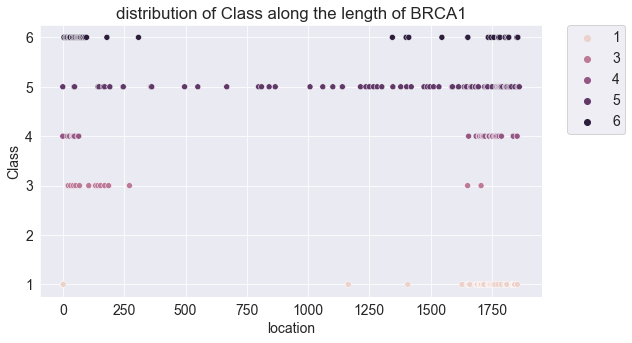

In [81]:
sns.scatterplot(data=brca,x='location',y='Class',hue='Class',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of Class along the length of BRCA1');

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px"> We can see that class 5 mutations are distributed throughout the length of the gene, while all other classes are concentrated in certain locations. In all probability, this class of mutations will disrupt the structure of the protein. class 1 mutations, are exclusively at the terminal end, which is responsible for the BRCA1 protein to interact with other proteins. class 6,3 and 4 are concentrated at the start of the protein, where these mutations will disrupt DNA binding activity, and at the end, where they will disrupt interactions</font>

### <font color='blue'> Let us study a few other heavily mutated genes to try to decipher a pattern </font>

In [82]:
# top 10 mutated genes
train_df.groupby('Gene')['Variation'].aggregate("count").sort_values(ascending=False).head(n=10)

Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Variation, dtype: int64

### schematic of TP53 protein

![](https://imgur.com/rdKuiQX.png)

image courtesy https://www.researchgate.net/figure/Structure-of-the-tetramer-formation-domain-in-p53-protein-a-Domain-structure-of-p53_fig1_323968961

#### The p53 protein is located in the nucleus of cells throughout the body, where it attaches (binds) directly to DNA. When the DNA in a cell becomes damaged by agents such as toxic chemicals, radiation, or ultraviolet (UV) rays from sunlight, this protein plays a critical role in determining whether the DNA will be repaired or the damaged cell will self-destruct (undergo apoptosis). If the DNA can be repaired, p53 activates other genes to fix the damage. If the DNA cannot be repaired, this protein prevents the cell from dividing and signals it to undergo death. By stopping cells with mutated or damaged DNA from dividing, p53 helps prevent the development of tumors

In [83]:
tp53=train_df[train_df['Gene'] == 'TP53']

In [85]:
tp53.groupby('Class')['Variation'].count()

Class
1    83
2     3
3     2
4    67
5     2
6     5
9     1
Name: Variation, dtype: int64

In [86]:
tp53['Variation'].nunique()

163

### In TP53, 163 mutations are classified into 7 classes

In [89]:
tp53['location']=tp53['Variation'].map(integer_mutation)

In [90]:
tp53.sort_values('location',inplace=True)

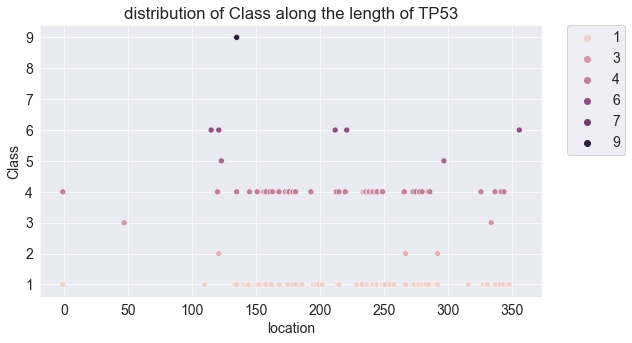

In [91]:
sns.scatterplot(data=tp53,x='location',y='Class',hue='Class',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of Class along the length of TP53');

### In the case of TP53, it is mostly mutated by class 1 and class 4 mutations and these are spread in the DNA binding domain of the protein, thus mostly disrupting this activity

### schematic of EGFR protein

![](https://imgur.com/LiUERaV.png)

image courtesy https://www.researchgate.net/figure/Schematic-of-the-EGFR-Gene-with-Locations-of-the-Mutation-Types_fig1_7479078

EGFR is a cell surface protein that binds to epidermal growth factor, thus inducing receptor dimerization and tyrosine autophosphorylation leading to cell proliferation. Mutations in this gene are associated with lung cancer. EGFR is a component of the cytokine storm which contributes to a severe form of Coronavirus Disease 2019 (COVID-19) resulting from infection with severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2)

In [93]:
egfr=train_df[train_df['Gene'] == 'EGFR']

In [102]:
egfr.groupby('Class')['Variation'].count()

Class
1     1
2    45
3     1
4     5
5     3
6     1
7    84
8     1
Name: Variation, dtype: int64

In [95]:
egfr['Variation'].nunique()

141

### In EGFR, 141 mutatitons are classified into 8 groups

In [97]:
egfr['location']=egfr['Variation'].map(integer_mutation)

In [98]:
egfr.sort_values('location',inplace=True)

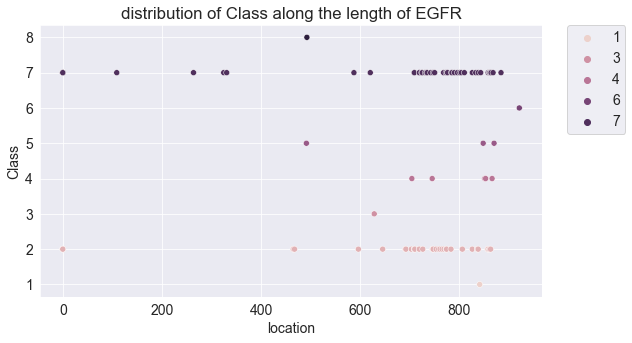

In [101]:
sns.scatterplot(data=egfr,x='location',y='Class',hue='Class',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of Class along the length of EGFR');

### <font color='blue'> EGFR protein is mostly affected by class 2 and class 7 mutations</font>

In [18]:
class_vs_mutation=train_df.groupby(['Gene','Class'])[['Variation']].nunique().sort_values(by='Variation',ascending=False).reset_index()

In [23]:
class_vs_mutation[class_vs_mutation['Gene']=='BRCA1']

,Gene,Class,Variation
1,BRCA1,5,90
6,BRCA1,1,60
7,BRCA1,6,53
12,BRCA1,4,46
47,BRCA1,3,15


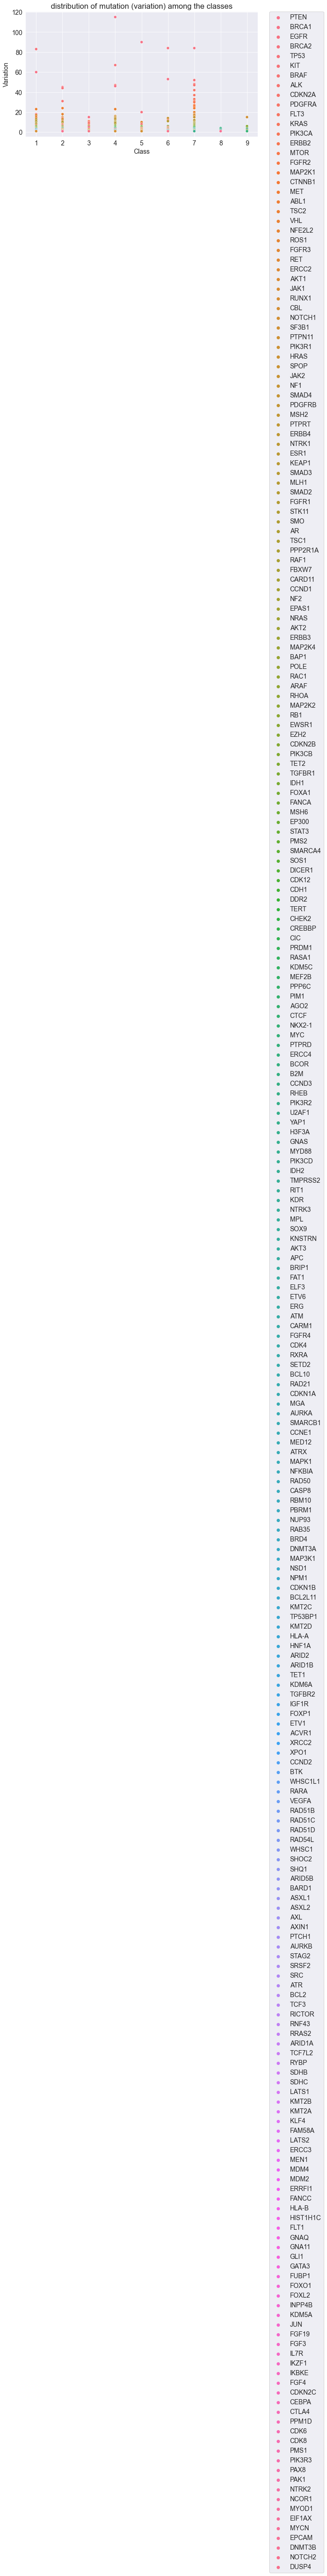

In [120]:
sns.scatterplot(data=class_vs_mutation,x='Class',y='Variation',hue='Gene',y_jitter=True);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('distribution of mutation (variation) among the classes');

### <font color='green'> We thus conclude our EDA.Both from the 3 extreme cases above, and the plot below, we see that most genes have limited mutations (variations), restricted to a particular class.Even, in the case of the 3 extreme cases above, most of the mutations, belonged to select classes. The median mutations per gene is 4, with most genes having but 1 mutation. These classes have a functional significance, which can be understood by reading the text. There is no direct correlation to the usual classification based on pathways or on location. This could be due to the fact that these mutations have been classified on clinical signifcance, and each protein has an unique structural organization. Thus we shall now use the tools of NLP to model the classification </font>

### <font color='blue'> Creation of ML model </font>

In [26]:
train_df.shape

(3321, 5)

In [27]:
train_df.isna().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [28]:
train_df[train_df['Text'].map(lambda x:not isinstance(x,str))]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [29]:
train_df.dropna(inplace=True)

In [30]:
train_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [31]:
y_train=train_df['Class']
X_train=train_df.drop('Class',axis=1)
train_df,validation_df,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.3,stratify=y_train) # stratification is important as classes are imbalanced

In [32]:
train_df.shape,y_train.shape

((2321, 4), (2321,))

In [33]:
set(y_train.tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [34]:
y_train_df = pd.DataFrame(y_train)

In [35]:
y_train_df.groupby('Class')['Class'].count()

Class
1    396
2    317
3     62
4    480
5    170
6    191
7    666
8     13
9     26
Name: Class, dtype: int64

In [36]:
validation_df.shape,y_validation.shape

((995, 4), (995,))

In [37]:
set(y_validation.tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9}

#### train data

In [38]:
train_df.head()

,ID,Gene,Variation,Text
2556,2556,BRCA1,W1837R,Abstract The BRCA1 gene from individuals at ...
2048,2048,SOS1,G434R,The identification of biologically significant...
946,946,PDGFRB,R561C,Abstract Infantile myofibromatosis (IM) is th...
731,731,ERBB2,N319D,We assessed somatic alleles of six receptor ty...
761,761,ERBB2,G309E,We assessed somatic alleles of six receptor ty...


#### validation data

In [39]:
validation_df.head()

,ID,Gene,Variation,Text
2474,2474,BRCA1,V1741G,Germline mutation analysis of BRCA1 gene has d...
3043,3043,KIT,Y823D,Activating mutations in Kit receptor tyrosine ...
529,529,TP53,P278R,Hepatocellular carcinoma (HCC) may develop acc...
1041,1041,TSC2,L792R,Tuberous sclerosis complex (TSC) is an autosom...
2694,2694,BRAF,G596V,The Ras/MAPK pathway is critical for human dev...


[link to destination](#destination)

### <font color='blue'>Text preprocessing</font>

In [40]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
revised_punctuation='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [42]:
revised_punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [43]:
len(set(words))

235892

In [44]:
nltk_words=set(words)

In [45]:
def cleanse_data(data):        
    if isinstance(data,str):
        no_punctuation = [char for char in data.replace('\n',' ') if char not in revised_punctuation]
        no_punctuation_txt = ''.join(no_punctuation)                   
        return no_punctuation_txt
    else:
        return "NA"

In [46]:
def reduce_words(data):
    data = data.split()
    words = [word for word in data if word not in nltk_words]
    text = " ".join(words)
    return text    

In [47]:
def word_count(text):
    text_lst=text.split()
    vector = [text_lst.count(str(word)) for word in text_lst]
    return vector[:300]

we have obtained the frequency distribution of words using freqdist

In [48]:
def freq_dist(data):
    data=data.split(" ")
    freq=FreqDist(data) # gets word frequency
    freq=sorted(freq.items(),key=lambda x:x[1], reverse=True) # sorts words from highest to lowest frequency
    return [item[1] for item in freq][:300] # returns a fixed length of 300 words

In [49]:
# References

In [50]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# https://www.kaggle.com/elemento/personalizedmedicine-rct

[Beginning of Notebook](#top)

In [51]:
def text_preprocessing(df):
    # remove punctuation
    df['cleaned_text'] = df['Text'].map(cleanse_data,na_action='ignore')
    # filtering all common english words
    df['cleaned_text'] = df['cleaned_text'].map(reduce_words,na_action='ignore')
    # count the length of original text
    df['Text_len'] = df['Text'].map(lambda x:len(str(x)))
    # count the length of cleaned text
    df['cleaned_text_len'] = df['cleaned_text'].map(lambda x:len(str(x)))

In [52]:
text_preprocessing(train_df)

In [53]:
text_preprocessing(validation_df)

In [54]:
train_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
2556,2556,BRCA1,W1837R,Abstract The BRCA1 gene from individuals at ...,Abstract BRCA1 individuals cancers mutations H...,159799,67472
2048,2048,SOS1,G434R,The identification of biologically significant...,variants genomes needed Independent exomes Lar...,31158,10839
946,946,PDGFRB,R561C,Abstract Infantile myofibromatosis (IM) is th...,Abstract Infantile myofibromatosis IM tissues ...,14546,5580
731,731,ERBB2,N319D,We assessed somatic alleles of six receptor ty...,We alleles genes mutated oncogenic Five genes ...,75739,30462
761,761,ERBB2,G309E,We assessed somatic alleles of six receptor ty...,We alleles genes mutated oncogenic Five genes ...,24679,10111


In [55]:
validation_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
2474,2474,BRCA1,V1741G,Germline mutation analysis of BRCA1 gene has d...,Germline BRCA1 has demonstrated These differen...,92090,35785
3043,3043,KIT,Y823D,Activating mutations in Kit receptor tyrosine ...,Activating mutations platelet-derived PDGFR tu...,307486,133923
529,529,TP53,P278R,Hepatocellular carcinoma (HCC) may develop acc...,Hepatocellular HCC pathways involving HBV TP53...,24680,10407
1041,1041,TSC2,L792R,Tuberous sclerosis complex (TSC) is an autosom...,Tuberous TSC characterized hamartomas organs t...,34409,15203
2694,2694,BRAF,G596V,The Ras/MAPK pathway is critical for human dev...,RasMAPK plays cancers Children germ-line mutat...,42931,17270


In [56]:
# implementing bag of words

In [57]:
bow_vectorizer = CountVectorizer(stop_words='english',max_features=1600)

In [58]:
# implementing tf-idf

In [59]:
tfidf_vectorizer = TfidfVectorizer(
   min_df=1, max_features=1600, strip_accents='unicode',lowercase =True,
   analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
   smooth_idf=True, sublinear_tf=True, stop_words = 'english')

### <font color='green'>converting text to numbers</font>

In [60]:
train_df_corpus = train_df['cleaned_text'].tolist()
validation_df_corpus = validation_df['cleaned_text'].tolist()

#### bag of words transformation

In [61]:
bow_vectorizer.fit(train_df_corpus)

CountVectorizer(max_features=1600, stop_words='english')

In [62]:
print("Vocabulary: ", bow_vectorizer.vocabulary_)

Vocabulary:  {'brca1': 333, 'individuals': 814, 'cancers': 348, 'mutations': 1011, 'alleles': 239, 'missense': 979, 'counseling': 451, 'cancer': 347, 'associated': 284, 'dimensional': 523, '37': 112, 'terms': 1466, 'loss': 909, 'function': 676, 'changes': 376, 'terminus': 1465, 'brct': 335, 'localized': 902, 'forms': 667, 'structure': 1423, 'based': 302, 'predicting': 1183, 'consequences': 425, '57': 145, 'germ': 703, 'line': 896, 'variants': 1552, 'integrated': 835, 'introduction': 841, 'inherited': 820, 'allowed': 241, 'developing': 516, 'approaches': 270, 'identifying': 776, 'causing': 358, 'domains': 543, 'functions': 678, 'mutants': 1008, 'sequences': 1356, 'structures': 1424, 'studies': 1425, 'proteins': 1216, '10': 16, '11': 27, '12': 31, 'including': 806, '13': 37, '14': 40, 'activates': 211, 'dna': 538, '15': 42, '16': 44, 'cooh': 441, 'factors': 629, 'rna': 1314, 'polymerase': 1169, 'ii': 782, 'holoenzyme': 758, '17': 47, 'activating': 212, 'binding': 314, '18': 48, '19': 50,

In [63]:
train_df_counts = bow_vectorizer.transform(train_df_corpus)
validation_df_counts = bow_vectorizer.transform(validation_df_corpus)

In [64]:
X_train_bow = train_df_counts.todense()
X_validation_bow = validation_df_counts.todense()

In [65]:
X_train_bow.shape

(2321, 1600)

In [66]:
X_validation_bow.shape

(995, 1600)

In [67]:
X_train_bow[0:100,0:100]

matrix([[2, 2, 1, ..., 2, 4, 4],
        [0, 0, 1, ..., 1, 3, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 1, 3, 0],
        [0, 1, 0, ..., 2, 2, 0],
        [0, 2, 0, ..., 5, 4, 0]], dtype=int64)

In [68]:
X_validation_bow[0:50,0:50]

matrix([[  0,   0,   0, ...,   2,   5,   4],
        [  0,   0,   1, ..., 107,  67,   0],
        [  0,   1,   0, ...,   3,   2,   0],
        ...,
        [  0,   0,   0, ...,   2,   1,   0],
        [  0,   0,   1, ...,   2,   3,   0],
        [  0,   0,   0, ...,   1,  14,   0]], dtype=int64)

In [69]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# save to csv file
savetxt('X_train_bow.csv', X_train_bow, delimiter=',')
savetxt('X_validation_bow.csv', X_validation_bow, delimiter=',')

In [70]:
y_train

2556    4
2048    2
946     6
731     5
761     7
2818    6
2132    4
600     1
206     7
96      4
2378    7
1800    6
2815    6
473     1
2158    4
1368    7
1217    5
2144    1
2076    6
1341    7
684     4
3182    2
1816    7
628     4
2820    6
6       5
2214    4
2960    2
1147    7
273     7
559     1
1001    1
1317    4
3251    7
1969    7
129     9
1078    1
2542    1
198     7
1445    4
3136    7
1736    4
1963    7
417     1
339     2
589     4
1381    7
1721    1
693     4
2122    7
2910    7
1492    1
2596    1
2859    6
1512    2
236     7
2430    6
1354    7
163     4
2119    2
208     2
3067    7
295     3
355     4
101     1
303     3
950     7
1935    7
248     2
1489    2
470     1
1696    1
608     1
2128    2
550     1
1777    1
2654    4
1188    7
3021    7
1956    4
1824    1
2487    5
2105    2
2146    1
722     6
360     4
2678    5
2379    1
1565    3
3113    3
2886    6
804     1
1700    5
2422    1
2411    6
875     5
1937    2
1612    4
2518    4
1592    4


In [71]:
X_train_bow=pd.read_csv('X_train_bow.csv',header=None).to_numpy()
X_validation_bow=pd.read_csv('X_validation_bow.csv',header=None).to_numpy()

In [72]:
X_train_bow.shape,y_train.shape

((2321, 1600), (2321,))

In [73]:
X_train_bow[0:10,0:10]

array([[ 2.,  2.,  1.,  0.,  0.,  1.,  4.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  7.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  3.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0.],
       [ 0., 15.,  2.,  6.,  2.,  3.,  7.,  4.,  0.,  2.],
       [ 3.,  2.,  0.,  0., 12.,  5.,  3.,  1.,  2.,  0.]])

#### tfidf transformation

In [74]:
tfidf_vectorizer.fit(train_df_corpus)

TfidfVectorizer(max_features=1600, ngram_range=(1, 3), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w+')

In [75]:
X_train_tfidf = tfidf_vectorizer.transform(train_df_corpus)
X_validation_tfidf = tfidf_vectorizer.transform(validation_df_corpus)

In [76]:
X_train_tfidf = X_train_tfidf.toarray()
X_validation_tfidf = X_validation_tfidf.toarray()

In [77]:
X_train_tfidf.shape

(2321, 1600)

In [78]:
X_train_tfidf[0:50,0:50]

array([[0.03812391, 0.        , 0.01714749, ..., 0.01431636, 0.02755001,
        0.01928304],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01910318,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04044911, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03048111, 0.03957264, 0.        , ..., 0.02531778, 0.02017064,
        0.        ]])

In [79]:
X_validation_tfidf.shape

(995, 1600)

In [80]:
X_validation_tfidf[0:50,0:50]

array([[0.03572306, 0.        , 0.        , ..., 0.01841912, 0.03306208,
        0.02480914],
       [0.04232815, 0.03521825, 0.05470765, ..., 0.04905272, 0.03119834,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01883669,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03123815, 0.03119172,
        0.        ],
       [0.01521372, 0.        , 0.        , ..., 0.        , 0.02186692,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03878241,
        0.        ]])

In [81]:
savetxt('X_train_tfidf.csv', X_train_tfidf, delimiter=',')
savetxt('X_validation_tfidf.csv', X_validation_tfidf, delimiter=',')

In [82]:
X_train_tfidf=pd.read_csv('X_train_tfidf.csv',header=None).to_numpy()
X_validation_tfidf=pd.read_csv('X_validation_tfidf.csv',header=None).to_numpy()

In [84]:
X_train_tfidf.shape,X_validation_tfidf.shape,y_train.shape,y_validation.shape

((2321, 1600), (995, 1600), (2321,), (995,))

### <font color='green'>creating baseline metrics using hard coded predicted values</font>

In [96]:
# create a dummy y value for getting the baseline accuracy
y_dummy_1 = random.rand(2321,9)

In [97]:
#y_dummy

In [99]:
onehot_encoder = OneHotEncoder(sparse=False)

In [100]:
y_train_roc = y_train.values.reshape(-1,1)

In [101]:
y_train_roc = onehot_encoder.fit_transform(y_train_roc)

In [102]:
y_validation_roc = y_validation.values.reshape(-1,1)

In [103]:
y_validation_roc = onehot_encoder.fit_transform(y_validation_roc)

In [104]:
y_dummy_1[0,:]

array([0.96959802, 0.4908404 , 0.20653905, 0.17495152, 0.70028975,
       0.86317747, 0.30018931, 0.33537418, 0.69486477])

In [105]:
# baseline loss metric value, random y values
log_loss(y_train,y_dummy_1)

2.4518792155751417

In [106]:
y_dummy_2=np.zeros((2321,9),dtype='float')

In [107]:
y_dummy_2[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [108]:
# baseline loss metric value, all probabilites for y set to zero
log_loss(y_train,y_dummy_2)

2.197224577336219

In [109]:
# baseline loss metric value, all probabilites for y set to 0.4
y_dummy_3=np.full((2321,9),0.4,dtype='float')

In [110]:
y_dummy_3[0,:]

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [111]:
log_loss(y_train,y_dummy_3)

2.1972245773362182

In [112]:
y_dummy_4=np.zeros((2321,9),dtype='float')

In [113]:
y_dummy_4[:,0]=1.0

In [114]:
y_dummy_4[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [115]:
# baseline loss metric value,probability at index 1 set to 1.0 for all y
log_loss(y_train,y_dummy_4) 

28.645904592935405

In [116]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
y_dummy_5=np.zeros((2321,9),dtype='float')
count=0
for x in X_train_bow:
    new_y_val=np.random.randint(0,9)
    y_dummy_5[count,new_y_val]=1.    
    count=count+1  

In [117]:
y_dummy_5[0,:]

array([0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [118]:
log_loss(y_train,y_dummy_5)

30.550671235998127

In [119]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
def get_dummy(train_df):
    y_dummy_5=np.zeros((2321,9),dtype='float') # creating the probability matrix for y values
    count=0
    for x in train_df:                        # iterating through the training dataset
        new_y_val=np.random.randint(0,9)      # creating random values for substituting index values
        y_dummy_5[count,new_y_val]=1.         # setting the random index value as 1.0
        count=count+1  
    return y_dummy_5    

In [120]:
def simulate_dummy(train_df,y_train):    
    for i in range(10):
        y_dummy=get_dummy(train_df)
        print(log_loss(y_train,y_dummy))

In [121]:
simulate_dummy(train_df,y_train)

2.29381813103966
2.29381813103966
2.2789371416407325
2.2789371416407325
2.3086991204385874
2.3086991204385874
2.29381813103966
2.3086991204385874
2.3086991204385874
2.3086991204385874


In [122]:
pd.DataFrame({"substitutions":["random","all zero","all 0.4","index 1","random index"],"log_loss":[2.49,2.19,2.19,28.59,2.4]})

,substitutions,log_loss
0,random,2.49
1,all zero,2.19
2,all 0.4,2.19
3,index 1,28.59
4,random index,2.40


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">Thus the lowermost limit for log loss score for an inaccurate model returns a value of 2.4 and hence our models should return better scores</font> 

### <font color='blue'>Logistic Regression Model</font>

Logistic regression is one of the most popular Machine Learning algorithms, which comes under the Supervised Learning technique. It is used for predicting the categorical dependent variable using a given set of independent variables

#### Logistic regression model without class weights

In [85]:
def logistic_regression(x_train,y_train,x_val):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs') # define the multinomial logistic regression model
    model.fit(x_train,y_train)
    predict_proba_train = model.predict_proba(x_train)
    predict_proba_val = model.predict_proba(x_val)
    predict_train = model.predict(x_train)
    predict_val = model.predict(x_val)
    result = {"predict_proba_train":predict_proba_train,"predict_proba_val":predict_proba_val,"predict_train":predict_train,"predict_val":predict_val}
    return result   

Logistic regression model with Bag of words transformation

In [86]:
LRmodel_BOW_base=logistic_regression(X_train_bow,y_train,X_validation_bow)

In [87]:
LRmodel_BOW_base['predict_proba_train'][0]

array([3.57021076e-01, 6.44833259e-55, 1.30164653e-07, 6.35574797e-01,
       7.40399613e-03, 1.60791103e-13, 1.07036280e-58, 7.11390957e-64,
       2.33661482e-77])

Logistic regression model with TFIDF transformation

In [88]:
LRmodel_TFIDF_base=logistic_regression(X_train_tfidf,y_train,X_validation_tfidf)

In [89]:
LRmodel_TFIDF_base['predict_proba_train'][0]

array([0.17619388, 0.01563301, 0.02791401, 0.29964731, 0.36313027,
       0.08956249, 0.01912994, 0.00401995, 0.00476914])

#### let us improve the model by class weights

In [90]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

In [91]:
class_weights

array([ 0.65123457,  0.81352962,  4.15949821,  0.53726852,  1.51699346,
        1.35020361,  0.38722055, 19.83760684,  9.91880342])

In [92]:
def logistic_regressionB(x_train,y_train,x_val):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs',class_weight='balanced') # define the multinomial logistic regression model
    model.fit(x_train,y_train)
    predict_proba_train = model.predict_proba(x_train)
    predict_proba_val = model.predict_proba(x_val)
    predict_train = model.predict(x_train)
    predict_val = model.predict(x_val)
    result = {"predict_proba_train":predict_proba_train,"predict_proba_val":predict_proba_val,"predict_train":predict_train,"predict_val":predict_val}
    return result   

Logistic regression model with Bag of words transformation

In [93]:
LRmodel_BOW_balanced=logistic_regressionB(X_train_bow,y_train,X_validation_bow)

In [94]:
LRmodel_BOW_balanced['predict_proba_train'][0]

array([2.99127692e-001, 8.75280564e-053, 2.65194096e-009, 6.78503304e-001,
       2.23690002e-002, 7.85038464e-010, 1.11191681e-052, 1.70432558e-096,
       1.08839949e-105])

Logistic regression model with TFIDF transformation

In [95]:
LRmodel_TFIDF_balanced=logistic_regressionB(X_train_tfidf,y_train,X_validation_tfidf)

In [96]:
LRmodel_TFIDF_balanced['predict_proba_train'][0]

array([0.12644171, 0.01284727, 0.08757804, 0.13042659, 0.50359255,
       0.10586396, 0.01310739, 0.01469399, 0.00544849])

#### Log Loss score for Logisic Regression model with unbalanced classes

In [97]:
bow_train_LR_logloss = log_loss(y_train,LRmodel_BOW_base['predict_proba_train'])
bow_val_LR_logloss = log_loss(y_validation,LRmodel_BOW_base['predict_proba_val'])
tfidf_train_LR_logloss = log_loss(y_train,LRmodel_TFIDF_base['predict_proba_train'])
tfidf_val_LR_logloss = log_loss(y_validation,LRmodel_TFIDF_base['predict_proba_val'])

In [98]:
pd.DataFrame({"transformer model":['Bag of words','TFIDF'],"Train Data":[bow_train_LR_logloss,tfidf_train_LR_logloss],"Validation Data":[bow_val_LR_logloss,tfidf_val_LR_logloss]})

,transformer model,Train Data,Validation Data
0,Bag of words,0.305976,3.907884
1,TFIDF,0.937559,1.125235


#### Log Loss score of Logistic Regression model after balancing classes with class weights

In [99]:
bow_train_LR_logloss = log_loss(y_train,LRmodel_BOW_balanced['predict_proba_train'])
bow_val_LR_logloss = log_loss(y_validation,LRmodel_BOW_balanced['predict_proba_val'])
tfidf_train_LR_logloss = log_loss(y_train,LRmodel_TFIDF_balanced['predict_proba_train'])
tfidf_val_LR_logloss = log_loss(y_validation,LRmodel_TFIDF_balanced['predict_proba_val'])

In [100]:
pd.DataFrame({"transformer model":['Bag of words','TFIDF'],"Train Data":[bow_train_LR_logloss,tfidf_train_LR_logloss],"Validation Data":[bow_val_LR_logloss,tfidf_val_LR_logloss]})

,transformer model,Train Data,Validation Data
0,Bag of words,0.384653,3.031349
1,TFIDF,1.103970,1.289098


#### The balancing of the classes has improved the prediction accuracy

In [101]:
target_names=['class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']

In [102]:
def get_f1(y_train,y_pred):    
    f1_list=[]
    for line in classification_report(y_train,y_pred, target_names=target_names).split('\n'):
        if 'class' in line:
            f1_list.append(line.split()[4])
    return f1_list        

In [103]:
bow_train_f1 = get_f1(y_train,LRmodel_BOW_balanced['predict_train'])
bow_val_f1 = get_f1(y_validation,LRmodel_BOW_balanced['predict_val'])

In [104]:
tfidf_train_f1 = get_f1(y_train,LRmodel_TFIDF_balanced['predict_train'])
tfidf_val_f1 = get_f1(y_validation,LRmodel_TFIDF_balanced['predict_val'])

In [105]:
train_label = ["train" for i in range(9)]
validation_label = ["validation" for i in range(9)]

In [106]:
matplotlib.rcParams['figure.figsize'] = (9, 5)

In [107]:
bow_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_train_f1,"dataset":train_label})
bow_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_val_f1,"dataset":validation_label})
bow_f1_df = pd.concat([bow_train_f1_df,bow_val_f1_df])

In [108]:
bow_train_f1_df['F1'] = pd.to_numeric(bow_train_f1_df['F1'])
bow_val_f1_df['F1'] = pd.to_numeric(bow_val_f1_df['F1'])
bow_f1_df['F1'] = pd.to_numeric(bow_f1_df['F1'])

In [109]:
tfidf_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_train_f1,"dataset":train_label})
tfidf_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_val_f1,"dataset":validation_label})
tfidf_f1_df = pd.concat([tfidf_train_f1_df,tfidf_val_f1_df])

In [110]:
tfidf_train_f1_df['F1'] = pd.to_numeric(tfidf_train_f1_df['F1'])
tfidf_val_f1_df['F1'] = pd.to_numeric(tfidf_val_f1_df['F1'])
tfidf_f1_df['F1'] = pd.to_numeric(tfidf_f1_df['F1'])

In [111]:
#y,z,a,b

### F1 scores for all the classes for Logistic Regression

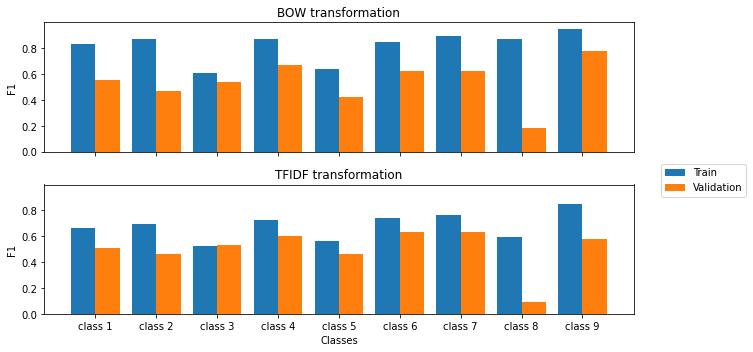

In [112]:
fig,axs = plt.subplots(2,sharex=True,sharey= 'col')
X = target_names
y = bow_train_f1_df["F1"]
z = bow_val_f1_df["F1"]

a = tfidf_train_f1_df['F1']
b = tfidf_val_f1_df['F1']
X_axis = np.arange(len(X))

axs[0].bar(X_axis - 0.2, y, 0.4, label = 'Train')
axs[0].bar(X_axis + 0.2, z, 0.4, label = 'Validation')
axs[0].set_title("BOW transformation")
axs[0].set_ylabel("F1")

axs[1].bar(X_axis - 0.2, a, 0.4, label = 'Train')
axs[1].bar(X_axis + 0.2, b, 0.4, label = 'Validation')
axs[1].set_title("TFIDF transformation")
axs[1].set_ylabel("F1")

plt.xticks(X_axis, X)
plt.xlabel("Classes")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.2))
plt.show()

In [113]:
cf_bow_train = confusion_matrix(y_train,LRmodel_BOW_balanced['predict_train'])
cf_bow_val = confusion_matrix(y_validation,LRmodel_BOW_balanced['predict_val'])
cf_tfidf_train = confusion_matrix(y_train,LRmodel_TFIDF_balanced['predict_train'])
cf_tfidf_val = confusion_matrix(y_validation,LRmodel_TFIDF_balanced['predict_val'])

#### Confusion Matrix for all the classes for BOW and TFIDF transformation

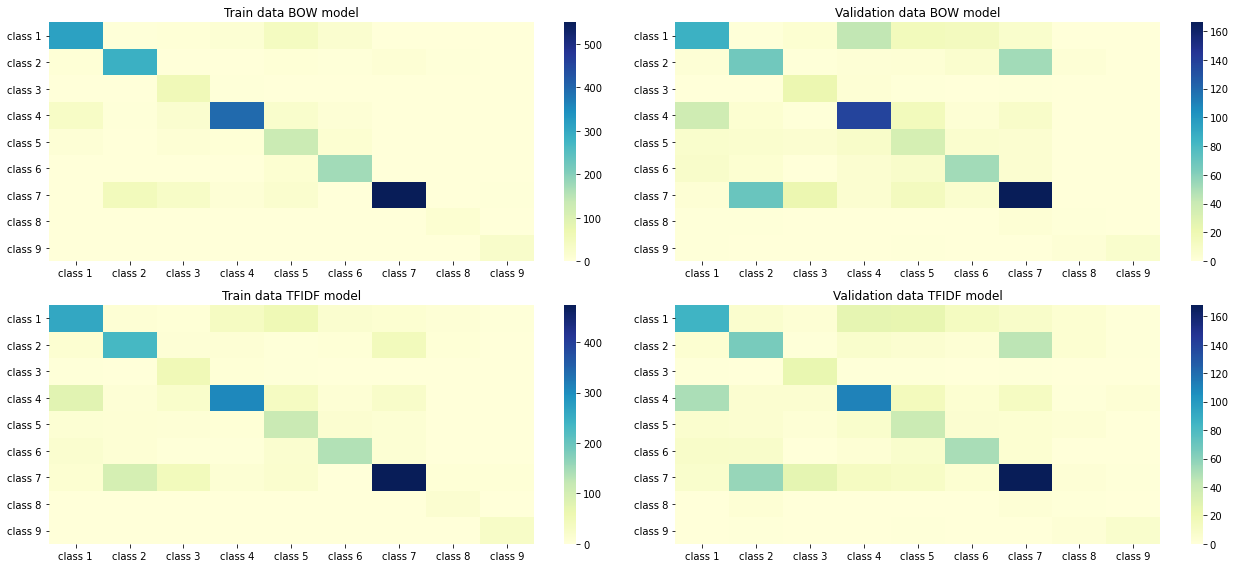

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,8))
sns.heatmap(cf_bow_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,0])
axes[0,0].set_title('Train data BOW model')
sns.heatmap(cf_bow_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,1])
axes[0,1].set_title('Validation data BOW model')
sns.heatmap(cf_tfidf_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,0])
axes[1,0].set_title('Train data TFIDF model')
sns.heatmap(cf_tfidf_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,1])
axes[1,1].set_title('Validation data TFIDF model')
plt.tight_layout()

### Inference from the analyzing the scoring matrix

#### The bag of words transformation overfits to the training data with low log loss and higher F1 scores across all classes. The TFIDF transformation produces a more balanced result, making it a better choice for building models. Both the transformations show a variation in the degree of prediction for different classes

### <font color='blue'> Multinomial Naive Bayes Model<font>

Naive Bayes classification technique is based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. It works well with discrete data and is a method of choice for text classification

In [115]:
sample_weights = class_weight.compute_sample_weight(class_weight='balanced',y = y_train) 

In [116]:
sample_weights

array([0.53726852, 0.81352962, 1.35020361, ..., 0.53726852, 0.38722055,
       1.51699346])

#### Naive Bayes model without balancing the samples

In [117]:
def naive_bayes(x_train,y_train,x_val,y_val):
    model =  MultinomialNB() # define the Naive Bayes model
    model.fit(x_train,y_train)
    print(model.class_count_)
    predict_proba_train = model.predict_proba(x_train)
    predict_proba_val = model.predict_proba(x_val)
    predict_train = model.predict(x_train)
    predict_val = model.predict(x_val)
    result = {"predict_proba_train":predict_proba_train,"predict_proba_val":predict_proba_val,"predict_train":predict_train,"predict_val":predict_val}
    return result   

In [118]:
NB_model_BOW_base = naive_bayes(X_train_bow,y_train,X_validation_bow,y_validation)

[396. 317.  62. 480. 170. 191. 666.  13.  26.]


In [119]:
NB_model_tfidf_base = naive_bayes(X_train_tfidf,y_train,X_validation_tfidf,y_validation)

[396. 317.  62. 480. 170. 191. 666.  13.  26.]


####  Let us add sample weights to the model to balance the classes

In [120]:
def naive_bayesB(x_train,y_train,x_val):
    model = MultinomialNB() # define the Naive bayes model
    model.fit(x_train,y_train,sample_weights)
    print(model.class_count_)
    predict_proba_train = model.predict_proba(x_train)
    predict_proba_val = model.predict_proba(x_val)
    predict_train = model.predict(x_train)
    predict_val = model.predict(x_val)
    result = {"predict_proba_train":predict_proba_train,"predict_proba_val":predict_proba_val,"predict_train":predict_train,"predict_val":predict_val}
    return result   

In [121]:
NB_model_BOW_balanced = naive_bayesB(X_train_bow,y_train,X_validation_bow)

[257.88888889 257.88888889 257.88888889 257.88888889 257.88888889
 257.88888889 257.88888889 257.88888889 257.88888889]


In [122]:
NB_model_tfidf_balanced = naive_bayesB(X_train_tfidf,y_train,X_validation_tfidf)

[257.88888889 257.88888889 257.88888889 257.88888889 257.88888889
 257.88888889 257.88888889 257.88888889 257.88888889]


#### Log Loss score for Naive Bayes model for BOW and TFIDF without class balance

In [123]:
bow_train_NB_logloss = log_loss(y_train,NB_model_BOW_base['predict_proba_train'])
bow_val_NB_logloss = log_loss(y_validation,NB_model_BOW_base['predict_proba_val'])
tfidf_train_NB_logloss = log_loss(y_train,NB_model_tfidf_base['predict_proba_train'])
tfidf_val_NB_logloss = log_loss(y_validation,NB_model_tfidf_base['predict_proba_val'])

In [124]:
pd.DataFrame({"transformer model":['Bag of words','TFIDF'],"Train Data":[bow_train_NB_logloss,tfidf_train_NB_logloss],"Validation Data":[bow_val_NB_logloss,tfidf_val_NB_logloss]})

,transformer model,Train Data,Validation Data
0,Bag of words,13.155513,15.865048
1,TFIDF,1.241465,1.324796


#### Log Loss score for Naive Bayes model for BOW and TFIDF after class balance

In [125]:
bow_train_NB_logloss = log_loss(y_train,NB_model_BOW_balanced['predict_proba_train'])
bow_val_NB_logloss = log_loss(y_validation,NB_model_BOW_balanced['predict_proba_val'])
tfidf_train_NB_logloss = log_loss(y_train,NB_model_tfidf_balanced['predict_proba_train'])
tfidf_val_NB_logloss = log_loss(y_validation,NB_model_tfidf_balanced['predict_proba_val'])

In [126]:
pd.DataFrame({"transformer model":['Bag of words','TFIDF'],"Train Data":[bow_train_NB_logloss,tfidf_train_NB_logloss],"Validation Data":[bow_val_NB_logloss,tfidf_val_NB_logloss]})

,transformer model,Train Data,Validation Data
0,Bag of words,13.078887,15.851806
1,TFIDF,1.351489,1.445151


#### Balancing of sample weights has reduced the accuracy of the Naive Bayes model

#### Let us study the Naive Bayes model without class balance, with other scoring matrices 

In [127]:
bow_train_f1 = get_f1(y_train,NB_model_BOW_base['predict_train'])
bow_val_f1 = get_f1(y_validation,NB_model_BOW_base['predict_val'])

In [128]:
tfidf_train_f1 = get_f1(y_train,NB_model_tfidf_base['predict_train'])
tfidf_val_f1 = get_f1(y_validation,NB_model_tfidf_base['predict_val'])

In [129]:
bow_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_train_f1,"dataset":train_label})
bow_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_val_f1,"dataset":validation_label})
bow_f1_df = pd.concat([bow_train_f1_df,bow_val_f1_df])

In [130]:
bow_train_f1_df['F1'] = pd.to_numeric(bow_train_f1_df['F1'])
bow_val_f1_df['F1'] = pd.to_numeric(bow_val_f1_df['F1'])
bow_f1_df['F1'] = pd.to_numeric(bow_f1_df['F1'])

In [131]:
tfidf_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_train_f1,"dataset":train_label})
tfidf_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_val_f1,"dataset":validation_label})
tfidf_f1_df = pd.concat([tfidf_train_f1_df,tfidf_val_f1_df])

In [132]:
tfidf_train_f1_df['F1'] = pd.to_numeric(tfidf_train_f1_df['F1'])
tfidf_val_f1_df['F1'] = pd.to_numeric(tfidf_val_f1_df['F1'])
tfidf_f1_df['F1'] = pd.to_numeric(tfidf_f1_df['F1'])

### F1 scores for all the classes for Naive Bayes model

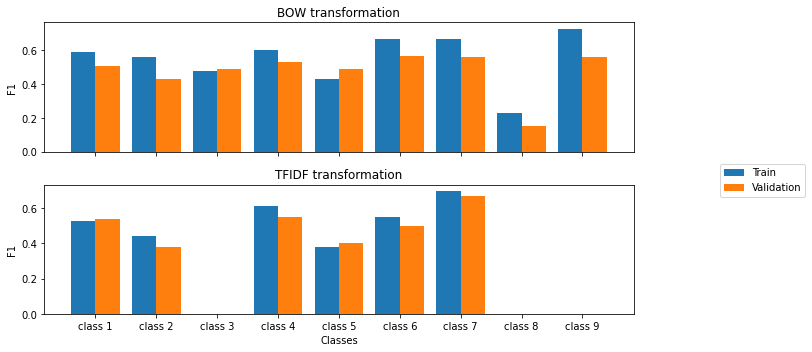

In [133]:
fig,axs = plt.subplots(2,sharex=True)
X = target_names
y = bow_train_f1_df["F1"]
z = bow_val_f1_df["F1"]

a = tfidf_train_f1_df['F1']
b = tfidf_val_f1_df['F1']
X_axis = np.arange(len(X))

axs[0].bar(X_axis - 0.2, y, 0.4, label = 'Train')
axs[0].bar(X_axis + 0.2, z, 0.4, label = 'Validation')
axs[0].set_title("BOW transformation")
axs[0].set_ylabel("F1")

axs[1].bar(X_axis - 0.2, a, 0.4, label = 'Train')
axs[1].bar(X_axis + 0.2, b, 0.4, label = 'Validation')
axs[1].set_title("TFIDF transformation")
axs[1].set_ylabel("F1")

plt.xticks(X_axis, X)
plt.xlabel("Classes")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.3, 1.2))
plt.show()

In [134]:
NB_model_BOW_balanced, NB_model_tfidf_balanced

({'predict_proba_train': array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
          0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
         [1.47395656e-012, 1.00000000e+000, 3.06558194e-057, ...,
          6.44682341e-026, 5.64062389e-062, 1.74308774e-145],
         [6.41270762e-067, 1.00000000e+000, 2.46992969e-049, ...,
          3.23976860e-031, 3.02648534e-094, 1.99995051e-213],
         ...,
         [4.41401022e-212, 1.65172822e-296, 2.22519379e-135, ...,
          3.40928973e-307, 0.00000000e+000, 0.00000000e+000],
         [1.00000000e+000, 2.84135048e-119, 1.01459970e-222, ...,
          1.42960462e-123, 4.05456352e-107, 6.90596070e-133],
         [3.95252517e-323, 0.00000000e+000, 0.00000000e+000, ...,
          0.00000000e+000, 0.00000000e+000, 0.00000000e+000]]),
  'predict_proba_val': array([[6.18970743e-310, 0.00000000e+000, 0.00000000e+000, ...,
          0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
         [0.00000000e+000, 1.00000000e+000, 

In [135]:
cf_bow_train = confusion_matrix(y_train,NB_model_BOW_base['predict_train'])
cf_bow_val = confusion_matrix(y_validation,NB_model_BOW_base['predict_val'])
cf_tfidf_train = confusion_matrix(y_train,NB_model_tfidf_base['predict_train'])
cf_tfidf_val = confusion_matrix(y_validation,NB_model_tfidf_base['predict_val'])

### Confusion Matrix for all the classes for BOW and TFIDF transformation

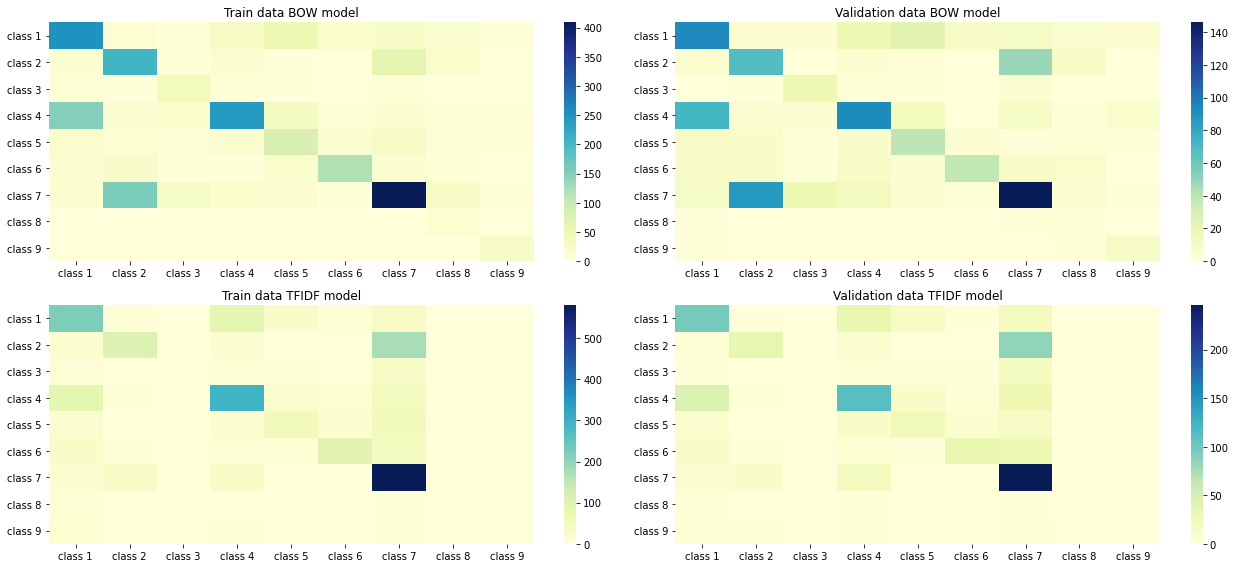

In [136]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,8))
sns.heatmap(cf_bow_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,0])
axes[0,0].set_title('Train data BOW model')
sns.heatmap(cf_bow_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,1])
axes[0,1].set_title('Validation data BOW model')
sns.heatmap(cf_tfidf_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,0])
axes[1,0].set_title('Train data TFIDF model')
sns.heatmap(cf_tfidf_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,1])
axes[1,1].set_title('Validation data TFIDF model')
plt.tight_layout()

### <font color='blue'> The Naive Bayes Classifier has performed poorly with the BOW model. One reason could be that there exists a relationship between the features. Without correction, the Naive Bayes model cannot be used with continious data and hence we are not modeling the TFIDF data </font>

### <font color='blue'> XGBoost Model<font>

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework

In [172]:
def xgboost_model(x_train,y_train,x_val):    
    model = XGBClassifier(objective="multi:softmax",eval_metric="logloss",
                          verbosity=0,tree_method="approx",seed=42) # define the XGBoost model
    model.fit(x_train,y_train)
    feature_importances = model.feature_importances_
    booster = model.get_booster()
    num_rounds = model.get_num_boosting_rounds()
    xgb_params = model.get_xgb_params()
    predict_proba_train = model.predict_proba(x_train)    
    predict_train = model.predict(x_train)
    predict_proba_val = model.predict_proba(x_val)
    predict_val = model.predict(x_val)
    
    result = {"predict_proba_train":predict_proba_train,"predict_train":predict_train,
              "predict_proba_val":predict_proba_val,"predict_val":predict_val,              
              "feature_importances":feature_importances,"booster":booster,
              "num_rounds":num_rounds,"xgb_params":xgb_params}
    return result,model   

In [173]:
xgb_result_BOW_base,xgb_model_BOW_base = xgboost_model(X_train_bow,y_train,X_validation_bow)

In [176]:
xgb_result_tfidf_base,xgb_model_tfidf_base = xgboost_model(X_train_tfidf,y_train,X_validation_tfidf)

In [138]:
# params=[{'n_estimators':[10,50,100]},{'max_depth':[1,4,6]},{'min_samples_split':[2,4]}]
# cv = KFold(n_splits=5, random_state=1, shuffle=True)
# xgb_grid_bow=GridSearchCV(estimator=xg_boost_model, param_grid=params,cv=cv,verbose=1)
# xgb_grid_bow.fit(X_train_bow, y_train)

In [141]:
#xgb_model_BOW_base

In [178]:
#xgb_model_tfidf_base

#### saving the model

In [139]:
#xg_boost_model_bow

In [140]:
#pickle.dump(xgb_grid_bow,open("xgb_grid_bow.sav","wb"))

####  Log Loss score for XGBoost model 

In [179]:
bow_train_XGB_logloss = log_loss(y_train,xgb_result_BOW_base['predict_proba_train'])
bow_val_XGB_logloss = log_loss(y_validation,xgb_result_BOW_base['predict_proba_val'])
tfidf_train_XGB_logloss = log_loss(y_train,xgb_result_tfidf_base['predict_proba_train'])
tfidf_val_XGB_logloss = log_loss(y_validation,xgb_result_tfidf_base['predict_proba_val'])

In [146]:
pd.DataFrame({"transformer model":['Bag of words','TFIDF'],"Train Data":[bow_train_XGB_logloss,tfidf_train_XGB_logloss],"Validation Data":[bow_val_XGB_logloss,tfidf_val_XGB_logloss]})

,transformer model,Train Data,Validation Data
0,Bag of words,0.201274,1.198868
1,TFIDF,0.198045,1.204503


### F1 scores for all classes of XGBoost model

In [147]:
bow_train_f1 = get_f1(y_train,xgb_result_BOW_base['predict_train'])
bow_val_f1 = get_f1(y_validation,xgb_result_BOW_base['predict_val'])

In [148]:
bow_val_f1

['0.58', '0.53', '0.36', '0.72', '0.44', '0.70', '0.74', '0.25', '0.50']

In [149]:
tfidf_train_f1 = get_f1(y_train,xgb_result_tfidf_base['predict_train'])
tfidf_val_f1 = get_f1(y_validation,xgb_result_tfidf_base['predict_val'])

In [150]:
tfidf_val_f1

['0.56', '0.48', '0.37', '0.68', '0.46', '0.70', '0.73', '0.29', '0.59']

In [151]:
bow_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_train_f1,"dataset":train_label})
bow_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":bow_val_f1,"dataset":validation_label})
bow_f1_df = pd.concat([bow_train_f1_df,bow_val_f1_df])

In [152]:
bow_train_f1_df['F1'] = pd.to_numeric(bow_train_f1_df['F1'])
bow_val_f1_df['F1'] = pd.to_numeric(bow_val_f1_df['F1'])
bow_f1_df['F1'] = pd.to_numeric(bow_f1_df['F1'])

In [153]:
tfidf_train_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_train_f1,"dataset":train_label})
tfidf_val_f1_df = pd.DataFrame({"Classes":target_names,"F1":tfidf_val_f1,"dataset":validation_label})
tfidf_f1_df = pd.concat([tfidf_train_f1_df,tfidf_val_f1_df])

In [154]:
tfidf_train_f1_df['F1'] = pd.to_numeric(tfidf_train_f1_df['F1'])
tfidf_val_f1_df['F1'] = pd.to_numeric(tfidf_val_f1_df['F1'])
tfidf_f1_df['F1'] = pd.to_numeric(tfidf_f1_df['F1'])

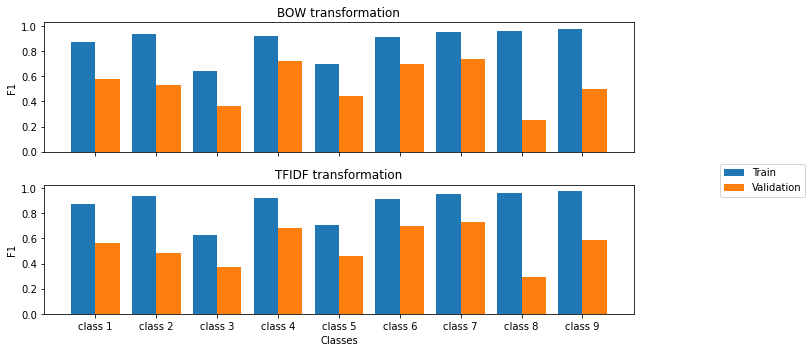

In [155]:
fig,axs = plt.subplots(2,sharex=True)
X = target_names
y = bow_train_f1_df['F1']
z = bow_val_f1_df['F1']

a = tfidf_train_f1_df['F1']
b = tfidf_val_f1_df['F1']
X_axis = np.arange(len(X))

axs[0].bar(X_axis - 0.2, y, 0.4, label = 'Train')
axs[0].bar(X_axis + 0.2, z, 0.4, label = 'Validation')
axs[0].set_title("BOW transformation")
axs[0].set_ylabel("F1")

axs[1].bar(X_axis - 0.2, a, 0.4, label = 'Train')
axs[1].bar(X_axis + 0.2, b, 0.4, label = 'Validation')
axs[1].set_title("TFIDF transformation")
axs[1].set_ylabel("F1")

plt.xticks(X_axis, X)
plt.xlabel("Classes")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.3, 1.2))
plt.show()

#### Confusion matrix for BOW and TFIDF transformation for XGB

In [180]:
cf_bow_train = confusion_matrix(y_train,xgb_result_BOW_base['predict_train'])
cf_bow_val = confusion_matrix(y_validation,xgb_result_BOW_base['predict_val'])
cf_tfidf_train = confusion_matrix(y_train,xgb_result_tfidf_base['predict_train'])
cf_tfidf_val = confusion_matrix(y_validation,xgb_result_tfidf_base['predict_val'])

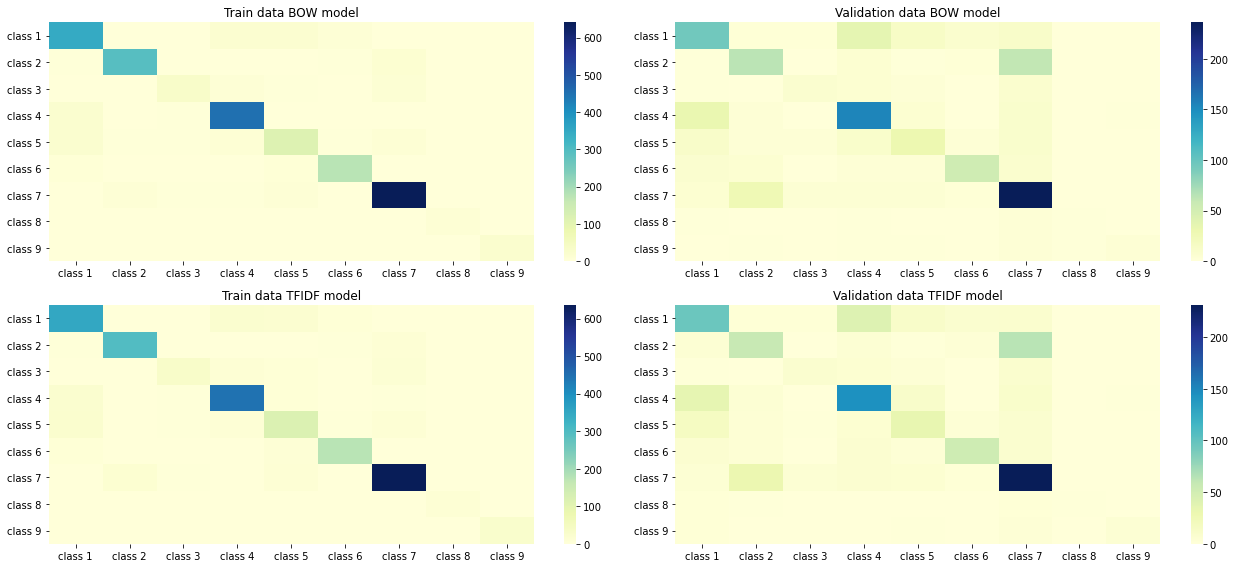

In [157]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,8))
sns.heatmap(cf_bow_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,0])
axes[0,0].set_title('Train data BOW model')
sns.heatmap(cf_bow_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[0,1])
axes[0,1].set_title('Validation data BOW model')
sns.heatmap(cf_tfidf_train, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,0])
axes[1,0].set_title('Train data TFIDF model')
sns.heatmap(cf_tfidf_val, cmap='YlGnBu', xticklabels = target_names, yticklabels = target_names,ax=axes[1,1])
axes[1,1].set_title('Validation data TFIDF model')
plt.tight_layout()

### <font color ='blue'>The xgboost model on the Bag of words transformed data, performs OK, with respect to the overall log loss score, but analyzing the classification report shows, that the F1 score is poor for several classes, and so this model will underperform with imbalanced datasets</font>

### <font color='blue'> A margin improvement is seen in the log loss score by using the TFIDF transformed dataset. However, the uneven efficiency in predicting the individual classes, remains a concern</font>

#### Stage2 test data

In [158]:
stage2_test_text_df = pd.read_csv('stage2_test_text.csv', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"])


In [159]:
stage2_test_text_df.shape

(986, 2)

In [160]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['Text'].progress_map(cleanse_data,na_action='ignore')

progress bar: 100%|██████████| 986/986 [00:09<00:00, 103.84it/s]


In [161]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['cleaned_text'].progress_map(reduce_words)

progress bar: 100%|██████████| 986/986 [00:03<00:00, 252.02it/s]


In [162]:
stage2_test_text_df.shape

(986, 3)

In [163]:
stage2_cleaned_view =pd.DataFrame({"Text":stage2_test_text_df['Text'].progress_map(lambda x:len(x)),"cleaned_text":stage2_test_text_df['cleaned_text'].map(lambda x:len(x))})
stage2_cleaned_view.head()

progress bar: 100%|██████████| 986/986 [00:00<00:00, 164390.97it/s]


,Text,cleaned_text
0,33403,14418
1,66400,29135
2,58544,26808
3,42023,17996
4,22499,8311


In [164]:
stage2_test_corpus = stage2_test_text_df['cleaned_text'].tolist()

In [165]:
X_stage2_test_bow = bow_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [166]:
X_stage2_test_tfidf = tfidf_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [167]:
X_stage2_test_bow.shape,X_stage2_test_tfidf.shape

((986, 1600), (986, 1600))

In [182]:
y_pred_stg2_bow_xgb = xgb_model_BOW_base.predict_proba(X_stage2_test_bow)

In [184]:
y_pred_stg2_tfidf_xgb = xgb_model_tfidf_base.predict_proba(X_stage2_test_tfidf)

In [188]:
np.savetxt("y_pred_stg2_bow_xgb.csv", y_pred_stg2_bow_xgb, delimiter=",")

In [189]:
np.savetxt("y_pred_stg2_tfidf_xgb.csv", y_pred_stg2_tfidf_xgb, delimiter=",")

In [ ]:
df=pd.DataFrame(columns=["Gene","Class","Variation","cleaned_text","cleaned_freq"])
for i in range(19):    
    df_new=class_9[class_9['cleaned_text'] == class_9['cleaned_text'].unique()[i]]
    df=pd.concat([df,df_new])

we have sorted the frequency dictionary based on values using the key parameter of sorted and higher values first using reverse

In [ ]:
sorted(test_dic.items(),key=lambda x:x[1], reverse=True)